# Utilisation données RASTA (radar seul) ou RALI_TC (radar+lidar) (RALI MAESTRO)
### Version modifiée Nat :
- V1 : 19 mai

In [1]:
import sys
import glob
import os, os.path
import string
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
from datetime import date
from datetime import datetime, timedelta
from scipy import ndimage
from matplotlib.colors import LogNorm
from collections import OrderedDict
from scipy import signal
import warnings
#import imp
from datetime import datetime
from subprocess import call
from numpy import linalg as la
import matplotlib.dates as md
from mpl_toolkits.mplot3d import Axes3D
#from scipy.optimize import curve_fit
#from scipy.optimize import leastsq
import ctypes
import time
#from datetime import datetime, date
from matplotlib.colors import LinearSegmentedColormap
import yaml

In [3]:
rali_cmap = { 'red': (
               (0.000000,0.871094,0.871094),(0.015625,0.816406,0.816406),(0.031250,0.761719,0.761719),(0.046875,0.707031,0.707031),
               (0.062500,0.656250,0.656250),(0.078125,0.601562,0.601562),(0.093750,0.546875,0.546875),(0.109375,0.496094,0.496094),
               (0.125000,0.433594,0.433594),(0.140625,0.371094,0.371094),(0.156250,0.308594,0.308594),(0.171875,0.246094,0.246094),
               (0.187500,0.183594,0.183594),(0.203125,0.121094,0.121094),(0.218750,0.058594,0.058594),(0.234375,0.000000,0.000000),
               (0.250000,0.000000,0.000000),(0.265625,0.000000,0.000000),(0.281250,0.000000,0.000000),(0.296875,0.000000,0.000000),
               (0.312500,0.000000,0.000000),(0.328125,0.000000,0.000000),(0.343750,0.000000,0.000000),(0.359375,0.000000,0.000000),
               (0.375000,0.000000,0.000000),(0.390625,0.000000,0.000000),(0.406250,0.000000,0.000000),(0.421875,0.000000,0.000000),
               (0.437500,0.000000,0.000000),(0.453125,0.000000,0.000000),(0.468750,0.000000,0.000000),(0.484375,0.000000,0.000000),
               (0.500000,0.121094,0.121094),(0.515625,0.246094,0.246094),(0.531250,0.371094,0.371094),(0.546875,0.496094,0.496094),
               (0.562500,0.621094,0.621094),(0.578125,0.746094,0.746094),(0.593750,0.871094,0.871094),(0.609375,0.996094,0.996094),
               (0.625000,0.996094,0.996094),(0.640625,0.996094,0.996094),(0.656250,0.996094,0.996094),(0.671875,0.996094,0.996094),
               (0.687500,0.996094,0.996094),(0.703125,0.996094,0.996094),(0.718750,0.996094,0.996094),(0.734375,0.996094,0.996094),
               (0.750000,0.996094,0.996094),(0.765625,0.996094,0.996094),(0.781250,0.996094,0.996094),(0.796875,0.996094,0.996094),
               (0.812500,0.996094,0.996094),(0.828125,0.996094,0.996094),(0.843750,0.996094,0.996094),(0.859375,0.996094,0.996094),
               (0.875000,0.933594,0.933594),(0.890625,0.871094,0.871094),(0.906250,0.808594,0.808594),(0.921875,0.746094,0.746094),
               (0.937500,0.683594,0.683594),(0.953125,0.621094,0.621094),(0.968750,0.558594,0.558594),(1.000000,0.496094,0.496094),
               (1.000000,0.496094,0.496094)),
    'green': (
              (0.000000,0.871094,0.871094),(0.015625,0.816406,0.816406),(0.031250,0.761719,0.761719),(0.046875,0.707031,0.707031),
              (0.062500,0.656250,0.656250),(0.078125,0.601562,0.601562),(0.093750,0.546875,0.546875),(0.109375,0.496094,0.496094),
              (0.125000,0.433594,0.433594),(0.140625,0.371094,0.371094),(0.156250,0.308594,0.308594),(0.171875,0.246094,0.246094),
              (0.187500,0.183594,0.183594),(0.203125,0.121094,0.121094),(0.218750,0.058594,0.058594),(0.234375,0.000000,0.000000),
              (0.250000,0.074219,0.074219),(0.265625,0.152344,0.152344),(0.281250,0.230469,0.230469),(0.296875,0.308594,0.308594),
              (0.312500,0.386719,0.386719),(0.328125,0.464844,0.464844),(0.343750,0.542969,0.542969),(0.359375,0.621094,0.621094),
              (0.375000,0.667969,0.667969),(0.390625,0.714844,0.714844),(0.406250,0.761719,0.761719),(0.421875,0.808594,0.808594),
              (0.437500,0.855469,0.855469),(0.453125,0.902344,0.902344),(0.468750,0.949219,0.949219),(0.484375,0.996094,0.996094),
              (0.500000,0.996094,0.996094),(0.515625,0.996094,0.996094),(0.531250,0.996094,0.996094),(0.546875,0.996094,0.996094),
              (0.562500,0.996094,0.996094),(0.578125,0.996094,0.996094),(0.593750,0.996094,0.996094),(0.609375,0.996094,0.996094),
              (0.625000,0.933594,0.933594),(0.640625,0.871094,0.871094),(0.656250,0.808594,0.808594),(0.671875,0.746094,0.746094),
              (0.687500,0.683594,0.683594),(0.703125,0.621094,0.621094),(0.718750,0.558594,0.558594),(0.734375,0.496094,0.496094),
              (0.750000,0.433594,0.433594),(0.765625,0.371094,0.371094),(0.781250,0.308594,0.308594),(0.796875,0.246094,0.246094),
              (0.812500,0.183594,0.183594),(0.828125,0.121094,0.121094),(0.843750,0.058594,0.058594),(0.859375,0.000000,0.000000),
              (0.875000,0.000000,0.000000),(0.890625,0.000000,0.000000),(0.906250,0.000000,0.000000),(0.921875,0.000000,0.000000),
              (0.937500,0.000000,0.000000),(0.953125,0.000000,0.000000),(0.968750,0.000000,0.000000),(1.000000,0.000000,0.000000),
              (1.000000,0.000000,0.000000)),
        'blue': (
             (0.000000,0.871094,0.871094),(0.015625,0.886719,0.886719),(0.031250,0.906250,0.906250),(0.046875,0.921875,0.921875),
             (0.062500,0.941406,0.941406),(0.078125,0.957031,0.957031),(0.093750,0.976562,0.976562),(0.109375,0.996094,0.996094),
             (0.125000,0.996094,0.996094),(0.140625,0.996094,0.996094),(0.156250,0.996094,0.996094),(0.171875,0.996094,0.996094),
             (0.187500,0.996094,0.996094),(0.203125,0.996094,0.996094),(0.218750,0.996094,0.996094),(0.234375,0.996094,0.996094),
             (0.250000,0.949219,0.949219),(0.265625,0.902344,0.902344),(0.281250,0.855469,0.855469),(0.296875,0.808594,0.808594),
             (0.312500,0.761719,0.761719),(0.328125,0.714844,0.714844),(0.343750,0.667969,0.667969),(0.359375,0.621094,0.621094),
             (0.375000,0.542969,0.542969),(0.390625,0.464844,0.464844),(0.406250,0.386719,0.386719),(0.421875,0.308594,0.308594),
             (0.437500,0.230469,0.230469),(0.453125,0.152344,0.152344),(0.468750,0.074219,0.074219),(0.484375,0.000000,0.000000),
             (0.500000,0.000000,0.000000),(0.515625,0.000000,0.000000),(0.531250,0.000000,0.000000),(0.546875,0.000000,0.000000),
             (0.562500,0.000000,0.000000),(0.578125,0.000000,0.000000),(0.593750,0.000000,0.000000),(0.609375,0.000000,0.000000),
             (0.625000,0.000000,0.000000),(0.640625,0.000000,0.000000),(0.656250,0.000000,0.000000),(0.671875,0.000000,0.000000),
             (0.687500,0.000000,0.000000),(0.703125,0.000000,0.000000),(0.718750,0.000000,0.000000),(0.734375,0.000000,0.000000),
             (0.750000,0.000000,0.000000),(0.765625,0.000000,0.000000),(0.781250,0.000000,0.000000),(0.796875,0.000000,0.000000),
             (0.812500,0.000000,0.000000),(0.828125,0.000000,0.000000),(0.843750,0.000000,0.000000),(0.859375,0.000000,0.000000),
             (0.875000,0.058594,0.058594),(0.890625,0.121094,0.121094),(0.906250,0.183594,0.183594),(0.921875,0.246094,0.246094),
             (0.937500,0.308594,0.308594),(0.953125,0.371094,0.371094),(0.968750,0.433594,0.433594),(1.000000,0.496094,0.496094),
             (1.000000,0.496094,0.496094))}


In [4]:
def make_cmap(colors, position=None, bit=False, n=256):
    '''
    make_cmap takes a list of tuples which contain RGB values. The RGB
    values may either be in 8-bit [0 to 255] (in which bit must be set to
    True when called) or arithmetic [0 to 1] (default). make_cmap returns
    a cmap with equally spaced colors.
    Arrange your tuples so that the first color is the lowest value for the
    colorbar and the last is the highest.
    position contains values from 0 to 1 to dictate the location of each color.
    '''
    import matplotlib as mpl
    import numpy as np
    bit_rgb = np.linspace(0,1,n)
    if position == None:
        position = np.linspace(0,1,len(colors))
    else:
        if len(position) != len(colors):
            sys.exit("position length must be the same as colors")
        elif position[0] != 0 or position[-1] != 1:
            sys.exit("position must start with 0 and end with 1")
    if bit:
        for i in range(len(colors)):
            colors[i] = (bit_rgb[colors[i][0]],
                         bit_rgb[colors[i][1]],
                         bit_rgb[colors[i][2]])
    cdict = {'red':[], 'green':[], 'blue':[]}
    for pos, color in zip(position, colors):
        cdict['red'].append((pos, color[0], color[0]))
        cdict['green'].append((pos, color[1], color[1]))
        cdict['blue'].append((pos, color[2], color[2]))

    cmap = mpl.colors.LinearSegmentedColormap('my_colormap',cdict,n)
    return cmap



deepblue=(0.00,0.00,0.40)
grey1=(.5,.5,.5)
grey2=(.2,.2,.2)
grey3=(.7,.7,.7)
grey4=(.8,.8,.8)
grey5=(.9,.9,.9)
yellow=(1.00,1.00,0.20)
black=(0,0,0)
white=(1,1,1)
cyan=(0/255., 179/255., 255/255.)
trueblue=(0.00,0.45,0.90)
brown=(102/255., 51/255., 0/255.)
lavander=(0.70,0.40,1.00)
purple=(0.7,0.0,0.7)
darkgreen=(0.04,0.2,0.)
green=(0,1,0)
red=(1,0,0)
darkscarlet=(0.40,0.00,0.13)
deeppink=(1.00,0.10,0.55)
oxfordblue=(0.00,0.05,0.30)
moonstoneblue=(0.45,0.63,0.76)
amber=(1.00,0.49,0.00)
brown2=(196/255., 155/255., 87/255.)


In [5]:
class att:
    def __init__(self):
        self.time = []
class lidarDATA:
    "LIDAR classic compiled data"
    def __init__(self):
        self.time = []
    def disp_attr(self):
        return list(self.__dict__.keys()) 
class lidarAtt:
    "LIDAR compiled data"
    def __init__(self):
        self.kind = 'LIDAR netcdf file attributes'
    def disp_attr(self):
        return list(self.__dict__.keys())        
class DATA:
    def __init__(self):
        self.time = []
        
def read_netcdf_noatt(file):
    d=DATA()
    #Technique for lazy boy or girl, it loads all variables itself
    nc = netCDF4.Dataset(file, 'r')
    variables_list=nc.variables.keys()
    
    for i, k in enumerate(variables_list):
        #print('importing:   ' + k)
        exec('d.' + k + '=' + 'nc.variables[' + "'" +k + "'" + '][:]')

    nc.close()
    return d

def read_netcdf(file):
    d=DATA()
    attribute=att()

    #Technique for lazy boy or girl, it loads all variables itself
    nc = netCDF4.Dataset(file, 'r')
    variables_list=nc.variables.keys()
    
    for i, k in enumerate(variables_list):
        #print('importing:   ' + k)
        exec('d.' + k + '=' + 'nc.variables[' + "'" +k + "'" + '][:]')

    for name in nc.ncattrs():
    #print 'Global attr', name, '=', getattr(nc,name)
        #print type(getattr(nc,name))
        #if isinstance(getattr(nc,name), unicode):
        #print(name)
        if isinstance(getattr(nc,name),str):
            exec('attribute.' + name + '=' + "'" + getattr(nc,name) + "'")
        else:
            #print 'attribute.' + name + '=' + str(getattr(nc,name))
            exec('attribute.' + name + '=' + str(getattr(nc,name)))
    nc.close()
    return d,attribute

def read_nc_rali(file):
    """
    reads netcdf data and retrieves variables attributes 
    """    
    data=lidarDATA()
    globalattributes=lidarAtt()
    attributes= att()
    nc = netCDF4.Dataset(file, 'r')   
    
    variables_list = list(nc.variables)
    data.var_names = [str(i) for i in variables_list] #for each variable, its name from the file

    for i in range(len(variables_list)):
        #print ('importing:   ' + variables_list[i])
        exec('data.' + variables_list[i] + '=' + 'nc.variables[' + "'" +variables_list[i] + "'" + '][:]')
        
        ##Deal with the attributes
        if hasattr(nc.variables[variables_list[i]],'units'):
            units=getattr(nc.variables[variables_list[i]],'units')
        else:
            units=''
        if hasattr(nc.variables[variables_list[i]],'long_name'):
            long_name=getattr(nc.variables[variables_list[i]],'long_name')
        else:
            long_name=''
        if hasattr(nc.variables[variables_list[i]],'missing_value'):
            missing_value=float(getattr(nc.variables[variables_list[i]],'missing_value'))
        else:
            missing_value=-999.
        
        exec('attributes.'+ variables_list[i]+'={}')
        exec('attributes.'+ variables_list[i]+'["units"]='+'"'+units+'"')
        exec('attributes.'+ variables_list[i]+'["long_name"]='+'"'+long_name+'"')
        exec('attributes.'+ variables_list[i]+'["missing_values"]='+'"'+str(missing_value)+'"')
        exec('attributes.'+ variables_list[i]+'["shape"]='+'str(np.shape(' + 'nc.variables[' + "'" +variables_list[i] + "'" + '][:]'+'))')
    #Global attributes
    for name in nc.ncattrs():
        if isinstance(getattr(nc,name), str):
            exec('globalattributes.' + name + '=' + '"' + getattr(nc,name) + '"')
        else:
            exec('globalattributes.' + name + '=' + str(getattr(nc,name)))

    nc.close() 
    
    return data,attributes,globalattributes

In [6]:
def time_axis_HH_MM(t,frac):
    ticklab=[time.strftime('%H:%M', time.gmtime(t[0]))]
    ind=1
    tt=np.ndarray(len(t))
    tt[0]=t[0]

    for i in range(1,len(t)):
        if frac > 0.:
            if (frac*t[i]/3600.) == (np.floor(frac*t[i]/3600.)):
                tt[ind]=t[i]
                ticklab.append(time.strftime('%H:%M', time.gmtime(t[i])))
                ind=ind+1
        else:
            if (float(i)/(-frac)) == (np.floor(float(i)/(-frac))):
                tt[ind]=t[i]
                ticklab.append(time.strftime('%H:%M', time.gmtime(t[i])))
                ind=ind+1
    tt=tt[0:ind]

    return tt,ticklab

def time_axis_HH_MM_SS(t,frac):
    ticklab=[time.strftime('%H:%M:%S', time.gmtime(t[0]))]
    ind=1
    tt=np.ndarray(len(t))
    tt[0]=t[0]

    for i in range(1,len(t)):
        if frac > 0.:
            if (frac*t[i]/3600.) == (np.floor(frac*t[i]/3600.)):
                tt[ind]=t[i]
                ticklab.append(time.strftime('%H:%M:%S', time.gmtime(t[i])))
                ind=ind+1
        else:
            if (float(i)/(-frac)) == (np.floor(float(i)/(-frac))):
                tt[ind]=t[i]
                ticklab.append(time.strftime('%H:%M:%S', time.gmtime(t[i])))
                ind=ind+1
    tt=tt[0:ind]

    return tt,ticklab

### colorar, labels etc 

In [7]:
colors_mask_355 = [grey3,grey1,black,trueblue,cyan,amber,yellow,lavander]
labels_mask_355=["negative range","noise","close range","attenuated molecular",'clear sky',"maybe particles","particles","do not know"]
n_mask_355=  len(labels_mask_355)
cmap_mask_355 = make_cmap(colors_mask_355, bit=False, n=n_mask_355)
mask_355_min=-3
mask_355_max=4

colors_mask_532 = [grey3,grey1,black,trueblue,cyan,amber,yellow,lavander]
labels_mask_532=["negative range","noise","close range","attenuated molecular",'clear sky',"maybe particles","particles","do not know"]
n_mask_532=  len(labels_mask_532)
cmap_mask_532 = make_cmap(colors_mask_532, bit=False, n=n_mask_532)
mask_532_min=-3
mask_532_max=4

colors_mask_hrs = [grey3,grey1,black,trueblue,cyan,amber]#,yellow]
labels_mask_hrs=["noise","negative range","close range","only molecular",'both particular and molecular',"only particular"]
n_mask_hrs=  len(labels_mask_hrs)
cmap_mask_hrs = make_cmap(colors_mask_hrs, bit=False, n=n_mask_hrs)
mask_hrs_min=-3
mask_hrs_max=2
    
colors_mask_doppler = [grey3,trueblue,cyan]#,trueblue,cyan,amber]#,yellow]
labels_mask_doppler=["noise","low quality Doppler","better quality Doppler"]
n_mask_doppler=  len(labels_mask_doppler)
cmap_mask_doppler = make_cmap(colors_mask_doppler, bit=False, n=n_mask_doppler)
mask_doppler_min=0
mask_doppler_max=2

colors_mask_depol = [grey3,black,white,trueblue,cyan]#,trueblue,cyan,amber]#,yellow]
labels_mask_depol=["negative range","close range","noise","molecular","particulate"]
n_mask_depol=  len(labels_mask_depol)
cmap_mask_depol = make_cmap(colors_mask_depol, bit=False, n=n_mask_depol)
mask_depol_min=-2
mask_depol_max=2

labels_target=["noise","negative range","extinguished","close range","attenuated molecular",'pure molecular',"liquid warm","ice cloud","supercooled layer","possible aerosol","aerosol" ,"surface","subsurface"]
colors_target = [white,white,grey2,grey1,darkscarlet,cyan,lavander,amber,red,moonstoneblue,green,brown2,yellow]
n_target=  len(labels_target)
print(n_target)
cmap_target = make_cmap(colors_target, bit=False, n=n_target)
target_min=-4
target_max=8

### Radar-lidar Instrument flag colour tab
tab_color_and_lab_inst_flag={}
tab_color_and_lab_inst_flag[0]=["-10:unknown",grey1]
tab_color_and_lab_inst_flag[1]=["-9:no radar & no lidar",black]
tab_color_and_lab_inst_flag[2]=["-8:subsurface only lidar",brown2]
tab_color_and_lab_inst_flag[3]=["-7:subsurface only radar",brown2]
tab_color_and_lab_inst_flag[4]=["-6:subsurface lidar & radar",brown2]
tab_color_and_lab_inst_flag[5]=["-5:surface only lidar",brown]
tab_color_and_lab_inst_flag[6]=["-4:surface only radar",brown]
tab_color_and_lab_inst_flag[7]=["-3:surface lidar & radar",brown]
tab_color_and_lab_inst_flag[8]=["-2:close range radar",yellow]
tab_color_and_lab_inst_flag[9]=["-1:close range lidar",red]
tab_color_and_lab_inst_flag[10]=["0:radar and lidar agree on clear sky",white]
tab_color_and_lab_inst_flag[11]=["1:radar don't detect anything and lidar is not available",grey5]
tab_color_and_lab_inst_flag[12]=["2:radar don't detect anything and lidar is noise",grey4]
tab_color_and_lab_inst_flag[13]=["3:radar don't detect anything and lidar is not noise",grey1]
tab_color_and_lab_inst_flag[14]=["4:lidar detects cloud, aerosol or precipitation and nothing on radar",deepblue]
tab_color_and_lab_inst_flag[15]=["5:radar and lidar detect particules",cyan]
tab_color_and_lab_inst_flag[16]=["6:radar detects but lidar extinguished",trueblue]
tab_color_and_lab_inst_flag[17]=["7:radar detects but lidar not available",lavander]
tab_color_and_lab_inst_flag[18]=["8:radar detects ghost echo lidar is not available",amber]
tab_color_and_lab_inst_flag[19]=["9:radar detects ghost echo lidar is available",green]
tab_color_and_lab_inst_flag[20]=["10:radar very strongly attenuated",purple]


labels_inst_flag=[]
colors_inst_flag=[]
for i in range(len(tab_color_and_lab_inst_flag)):
    labels_inst_flag.append(tab_color_and_lab_inst_flag[i][0])
    colors_inst_flag.append(tab_color_and_lab_inst_flag[i][1])

n_inst_flag=  len(labels_inst_flag)

cmap_inst_flag = make_cmap(colors_inst_flag, bit=False, n=n_inst_flag)
inst_flag_min=-10
inst_flag_max=10

### Radar-lidar Target classification colour tab

TC_tab_color_and_lab={}
TC_tab_color_and_lab[0]=["-2:unknown",grey1]
TC_tab_color_and_lab[1]=["-1:surface radar or lidar",brown2]
TC_tab_color_and_lab[2]=["0:clear sky confirmed by lidar",white]
TC_tab_color_and_lab[3]=["1:don't know if liq",grey5]
TC_tab_color_and_lab[4]=["2:liquid clouds and warm rain",deepblue]
TC_tab_color_and_lab[5]=["3:ice clouds",cyan]
TC_tab_color_and_lab[6]=["4:supercooled ",deeppink]
TC_tab_color_and_lab[7]=["5:mixed phase",lavander]
TC_tab_color_and_lab[8]=["6:melting layer",red]
TC_tab_color_and_lab[9]=["7:cold rain",green]
TC_tab_color_and_lab[10]=["8:aerosol",yellow]
TC_tab_color_and_lab[11]=["9:clear for radar but strong attenuation",moonstoneblue]

labels_TC_flag=[]
colors_TC_flag=[]
for i in range(len(TC_tab_color_and_lab)):
    labels_TC_flag.append(TC_tab_color_and_lab[i][0])
    colors_TC_flag.append(TC_tab_color_and_lab[i][1])

n_TC_flag=  len(labels_TC_flag)
print(len(labels_TC_flag))

cmap_TC_flag = make_cmap(colors_TC_flag, bit=False, n=n_TC_flag)
TC_flag_min=-2
TC_flag_max=9


13
12


# Main

In [8]:
warnings.filterwarnings("ignore")
cmap = LinearSegmentedColormap('my_colormap', rali_cmap, 100)

In [9]:
### Partie à mettre à jour
campaign='MAESTRO'
main_path='/homedata/nkaminski/THESE/maestro_rasta/data/'
#YAML files
path_yaml='/Users/delanoe/Work/rali/campaign_analysis/MAESTRO/segments/'

files_rali=sorted(glob.glob(main_path+'*.nc'))

In [10]:
#List available files
o=0
for file in files_rali:
    temp, name_file = os.path.split(file)
    print(name_file,'['+str(o)+']')
    o=o+1

ch=int(input('>'))       # 2ème vol du 10/09 : n°21
print('fichier choisi : n°', ch)

target_classification_rali_MAESTRO_20240810_F23_nshots_100_v1.0.nc [0]
target_classification_rali_MAESTRO_20240811_F24_nshots_100_v1.0.nc [1]
target_classification_rali_MAESTRO_20240813_F25_nshots_100_v1.0.nc [2]
target_classification_rali_MAESTRO_20240813_F26_nshots_100_v1.0.nc [3]
target_classification_rali_MAESTRO_20240815_F27_nshots_100_v1.0.nc [4]
target_classification_rali_MAESTRO_20240816_F28_nshots_100_v1.0.nc [5]
target_classification_rali_MAESTRO_20240816_F29_nshots_100_v1.0.nc [6]
target_classification_rali_MAESTRO_20240819_F30_nshots_100_v1.0.nc [7]
target_classification_rali_MAESTRO_20240820_F31_nshots_100_v1.0.nc [8]
target_classification_rali_MAESTRO_20240822_F32_nshots_100_v1.0.nc [9]
target_classification_rali_MAESTRO_20240822_F33_nshots_100_v1.0.nc [10]
target_classification_rali_MAESTRO_20240825_F34_nshots_100_v1.0.nc [11]
target_classification_rali_MAESTRO_20240826_F36_nshots_100_v1.0.nc [12]
target_classification_rali_MAESTRO_20240827_F37_nshots_100_v1.0.nc [13]
ta

In [11]:
file_in=files_rali[ch]

### load rali data

In [12]:
rali,att_rali,glob_att_rali=read_nc_rali(file_in)
print(glob_att_rali.Day,'F'+glob_att_rali.Flight)

20240910 F46


In [13]:
### Ease plotting...
rali.dtimes = rali.time[1:] - rali.time[:-1]
rali.holes_ind = [i for i, g in enumerate(rali.dtimes) if g > 60.]
rali.M=np.ones(np.shape(rali.lng_cal_att_back_532))
rali.M[rali.holes_ind ,:] = -3
rali.height_2D[np.ma.getmaskarray(rali.height_2D)]=-999.


### Prepare some data

In [14]:
rali.rasta_Z_interpolated_clean=np.ma.array(rali.rasta_Z_interpolated.copy(), \
mask=(rali.rasta_flag != 1) & (rali.rasta_flag != 2) & (rali.rasta_flag_Z_interpolated != 3) & (rali.rasta_flag_Z_interpolated != 2))

rali.lng_cal_att_back_532_clean=np.ma.array(rali.lng_cal_att_back_532.copy(), \
mask=(rali.lng_mask_532 < -1 ))

rali.lng_cal_att_back_355_clean=np.ma.array(rali.lng_cal_att_back_355_par+rali.lng_cal_att_back_355_cross, \
mask=(rali.lng_mask_355 < -1 ))


#Mask high spectral resolution 355 nm: 
#-3: noise
#-2: negative range
#-1: close range
#0: only molecular
#1: both particular and molecular
#2: only particular

rali.lng_cal_att_mol_back_355_clean=np.ma.array(rali.lng_cal_att_mol_back_355, \
mask=(rali.lng_mask_hsr < -1 ))

rali.lng_cal_att_part_back_355_clean=np.ma.array(rali.lng_cal_att_part_back_355, \
mask=(rali.lng_mask_hsr < -1 ) | (rali.lng_mask_hsr == 0))



In [15]:
h_max=8.

if glob_att_rali.Flight =='23':
    h_min=-0.1;    h_max=7.
if glob_att_rali.Flight =='24':
    h_min=-0.1;    h_max=7.
if glob_att_rali.Flight =='25':
    h_min=-0.1;    h_max=7.
if glob_att_rali.Flight =='26':
    h_min=-0.1;    h_max=7.
if glob_att_rali.Flight =='27':
    h_min=-0.1;    h_max=8.
if glob_att_rali.Flight =='28':
    h_min=-0.1;    h_max=7.
if glob_att_rali.Flight =='29':
    h_min=-0.1;    h_max=6.        
if glob_att_rali.Flight =='30':
    h_min=-0.1;    h_max=11.
if glob_att_rali.Flight =='31':
    h_min=-0.1;    h_max=7. 
if glob_att_rali.Flight =='32':
    h_min=-0.1;    h_max=7. 
if glob_att_rali.Flight =='33':
    h_min=-0.1;    h_max=8.
if glob_att_rali.Flight =='34':
    h_min=-0.1;    h_max=7.5 
if glob_att_rali.Flight =='35':
    h_min=-0.1;    h_max=14.
if glob_att_rali.Flight =='36':
    h_min=-0.1;    h_max=14.
if glob_att_rali.Flight =='37':
    h_min=-0.1;    h_max=7.5
if glob_att_rali.Flight =='38':
    h_min=-0.1e3;    h_max=7.5
if glob_att_rali.Flight =='39':
    h_min=-0.1;    h_max=8.
if glob_att_rali.Flight =='40':
    h_min=-0.1;    h_max=7.
if glob_att_rali.Flight=='41':
    h_min=-0.1;    h_max=2.5
if glob_att_rali.Flight=='42':
    h_min=-0.1;    h_max=2.5
if glob_att_rali.Flight=='43':
    h_min=-0.1;    h_max=14.
if glob_att_rali.Flight=='44':
    h_min=-0.1;    h_max=5.
if glob_att_rali.Flight=='45':
    h_min=-0.1;    h_max=16.
if glob_att_rali.Flight=='46':
    h_min=-0.1;    h_max=15.


    
    
h_min=-0.1
t_min=np.min(rali.time)
t_max=np.max(rali.time) 

tt,ticklab=time_axis_HH_MM(np.arange(np.floor(t_min/3600.),np.ceil(t_max/3600.),.25)*3600.,-1.)


In [16]:
num_FL=glob_att_rali.Flight
date_FL=glob_att_rali.Day
print(num_FL,date_FL)
if int(num_FL) < 10:    
    num_FL_saf='0'+num_FL
    datefl=date_FL
    flight_number=num_FL
    print(flight_number)
    if int(flight_number) > 9:
        file_yaml=path_yaml+'as'+datefl[2:4]+'00'+flight_number+'.yaml'        
    else:
        file_yaml = path_yaml+'as'+datefl[2:4]+'000'+flight_number+'.yaml'
else:
    datefl=date_FL
    flight_number=num_FL
    file_yaml=path_yaml+'as'+datefl[2:4]+'00'+flight_number+'.yaml'        
print(file_yaml)
try:
    print(file_yaml)  
    with open(file_yaml) as file_name:
        information_yaml = yaml.full_load(file_name)    
except:
    print('Pas de YAML')

#print(information_yaml)
# try:
#     print(file_yaml)  
#     with open(file_yaml) as file_name:
#         information_yaml = yaml.full_load(file_name)    
#         #number of rectangles
#         #num_rectangles=0
#         num_vad=0
#         for i in range(len(information_yaml["segments"])):
#             #print(information_yaml["segments"][i])
#             if (information_yaml["segments"][i]["note"]) == 'VAD':
#                 num_vad=num_vad+1

#     t_start_sec_vad=np.zeros([num_vad,])
#     t_end_sec_vad=np.zeros([num_vad,])

#     for r in range(num_vad):
#         #print(information_yaml["segments"][r]["name"])
#         t_start=information_yaml["segments"][r]["start"]
#         t_end=information_yaml["segments"][r]["end"]
#         t_start_sec_vad[r]=t_start.hour*3600.+t_start.minute*60.+t_start.second
#         t_end_sec_vad[r]=t_end.hour*3600.+t_end.minute*60.+t_end.second
#     print(t_start_sec_vad,t_end_sec_vad)
# except:
#     print('Pas de YAML')
    

46 20240910
/Users/delanoe/Work/rali/campaign_analysis/MAESTRO/segments/as240046.yaml
/Users/delanoe/Work/rali/campaign_analysis/MAESTRO/segments/as240046.yaml
Pas de YAML


## Global view

In [17]:
#font=12

fig=plt.figure(num=1, figsize=(16, 18), dpi=100, facecolor='w', edgecolor='k')

ax1=plt.subplot(4,1,1)
plt.pcolormesh(rali.time,rali.height_2D.T,rali.rasta_Z_interpolated_clean.T,cmap=cmap)
plt.plot(rali.time,rali.altitude,'k')
plt.clim(-40.,25.)
cb=plt.colorbar() ; cb.set_label('Reflectivity (dBZ)',fontsize=10)
plt.grid()
plt.xticks( tt, ticklab)
plt.xlim(t_min,t_max)
plt.ylim(h_min,h_max)
plt.ylabel('Height [km]')
pos1 = ax1.get_position().bounds
plt.title('F'+glob_att_rali.Flight+' '+glob_att_rali.Day, fontsize=16)


plt.subplot(4,1,2)
plt.pcolormesh(rali.time,rali.height_2D.T,np.ma.array(rali.lng_cal_att_mol_back_355_clean.copy(), mask=(rali.M < 0) ).T,norm=LogNorm(vmin=1.e-7, vmax=1.e-4),cmap=cmap)
plt.plot(rali.time,rali.altitude,'k')
cb=plt.colorbar() ; cb.set_label('Molecular backscatter \n355 (m-1 sr-1)',fontsize=10)
plt.grid()
plt.xticks( tt, ticklab)
plt.xlim(t_min,t_max)
plt.ylim(h_min,h_max)
plt.ylabel('Height [km]')

plt.subplot(4,1,3)
plt.pcolormesh(rali.time,rali.height_2D.T,np.ma.array(rali.lng_cal_att_part_back_355_clean.copy(), mask=(rali.M < 0) ).T,norm=LogNorm(vmin=1.e-7, vmax=1.e-4),cmap=cmap)
plt.plot(rali.time,rali.altitude,'k')
cb=plt.colorbar() ; cb.set_label('Particulate backscatter \n355 (m-1 sr-1)',fontsize=10)
plt.grid()
plt.xticks( tt, ticklab)
plt.xlim(t_min,t_max)
plt.ylim(h_min,h_max)
plt.ylabel('Height [km]')


plt.subplot(4,1,4)
plt.pcolormesh(rali.time,rali.height_2D.T,rali.rasta_Vz.T,cmap=cmap)
plt.plot(rali.time,rali.altitude,'k')
plt.clim(-5.,2.)
cb=plt.colorbar() ; cb.set_label('Vz (m/s)',fontsize=10)
plt.grid()
plt.xticks( tt, ticklab)
plt.xlim(t_min,t_max)
plt.ylim(h_min,h_max)
plt.ylabel('Height [km]')



Text(0, 0.5, 'Height [km]')

Error in callback <function flush_figures at 0x7f520745af20> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

In [ ]:
fig=plt.figure(num=1, figsize=(16, 18), dpi=100, facecolor='w', edgecolor='k')

ax1=plt.subplot(4,1,1)
plt.pcolormesh(rali.time,rali.height_2D.T,rali.rasta_Z_interpolated_clean.T,cmap=cmap)
plt.plot(rali.time,rali.altitude,'k')
plt.clim(-40.,25.)
cb=plt.colorbar() ; cb.set_label('Reflectivity (dBZ)',fontsize=10)
plt.grid()
plt.xticks( tt, ticklab)
plt.xlim(t_min,t_max)
plt.ylim(h_min,h_max)
plt.ylabel('Height [km]')
pos1 = ax1.get_position().bounds
plt.title('F'+glob_att_rali.Flight+' '+glob_att_rali.Day, fontsize=16)


plt.subplot(4,1,2)
plt.pcolormesh(rali.time,rali.height_2D.T,np.ma.array(rali.lng_cal_att_back_532_clean.copy(), mask=(rali.M < 0) ).T,norm=LogNorm(vmin=1.e-7, vmax=1.e-4),cmap=cmap)
plt.plot(rali.time,rali.altitude,'k')
cb=plt.colorbar() ; cb.set_label('Attenuated backscatter \n532 (m-1 sr-1)',fontsize=10)
plt.grid()
plt.xticks( tt, ticklab)
plt.xlim(t_min,t_max)
plt.ylim(h_min,h_max)
plt.ylabel('Height [km]')

plt.subplot(4,1,3)
plt.pcolormesh(rali.time,rali.height_2D.T,rali.rasta_Vz.T,cmap=cmap)
plt.plot(rali.time,rali.altitude,'k')
plt.clim(-5.,2.)
cb=plt.colorbar() ; cb.set_label('Vz (m/s)',fontsize=10)
plt.grid()
plt.xticks( tt, ticklab)
plt.xlim(t_min,t_max)
plt.ylim(h_min,h_max)
plt.ylabel('Height [km]')


In [ ]:
fig=plt.figure(num=1, figsize=(16, 18), dpi=100, facecolor='w', edgecolor='k')

ax1=plt.subplot(4,1,1)

plt.pcolormesh(rali.time,rali.height_2D.T,np.ma.array(rali.lng_mask_532.copy(), mask=((rali.M < 0)) ).T,cmap=cmap_mask_355)
plt.plot(rali.time,rali.altitude,'k')
plt.grid()
plt.clim(mask_532_min,mask_532_max)
tick_locs = ((np.arange(n_mask_532) + 0.5)*(n_mask_532-1)/n_mask_532)+mask_532_min
cb=plt.colorbar() ; 
cb.ax.set_title(r"Mask 532 nm")  
cb.set_ticks(tick_locs)
cb.set_ticklabels(np.arange(n_mask_532))
cb.set_ticklabels(labels_mask_532)
plt.ylim(h_min,h_max)
plt.ylabel('Height [km]',fontsize=12)
plt.xticks( tt, ticklab,fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(t_min,t_max)
plt.title(glob_att_rali.Day+' F'+glob_att_rali.Flight,fontsize=16)


ax2=plt.subplot(4,1,2)

plt.pcolormesh(rali.time,rali.height_2D.T,np.ma.array(rali.lng_mask_355.copy(), mask=((rali.M < 0)) ).T,cmap=cmap_mask_355)
plt.plot(rali.time,rali.altitude,'k')
plt.grid()
plt.clim(mask_355_min,mask_355_max)
tick_locs = ((np.arange(n_mask_355) + 0.5)*(n_mask_355-1)/n_mask_355)+mask_355_min
cb=plt.colorbar() ; 
cb.ax.set_title(r"Mask 355 nm")  
cb.set_ticks(tick_locs)
cb.set_ticklabels(np.arange(n_mask_355))
cb.set_ticklabels(labels_mask_355)
plt.ylim(h_min,h_max)
plt.ylabel('Height [km]',fontsize=12)
plt.xticks( tt, ticklab,fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(t_min,t_max)


plt.subplot(4,1,3)
plt.pcolormesh(rali.time,rali.height_2D.T,np.ma.array(rali.lng_target_classification_532.copy(), mask=rali.M < 0).T,cmap=cmap_target)
plt.plot(rali.time,rali.altitude,'k')
plt.grid()
plt.xticks( tt, ticklab,fontsize=12)
plt.xlim(t_min,t_max)
plt.ylim(h_min,h_max)
plt.ylabel('Height [km]',fontsize=12)
plt.clim(target_min,target_max)
tick_locs = ((np.arange(n_target) + 0.5)*(n_target-1)/n_target)+target_min
cb=plt.colorbar() ; 
cb.ax.set_title(r"Target 532 nm")  
cb.set_ticks(tick_locs)
cb.set_ticklabels(labels_target)

plt.subplot(4,1,4)
plt.pcolormesh(rali.time,rali.height_2D.T,np.ma.array(rali.lng_target_classification_355.copy(), mask=rali.M < 0).T,cmap=cmap_target)
plt.plot(rali.time,rali.altitude,'k')
plt.grid()
plt.xticks( tt, ticklab,fontsize=12)
plt.xlim(t_min,t_max)
plt.ylim(h_min,h_max)
plt.ylabel('Height [km]',fontsize=12)
plt.clim(target_min,target_max)
tick_locs = ((np.arange(n_target) + 0.5)*(n_target-1)/n_target)+target_min
cb=plt.colorbar() ; 
cb.ax.set_title(r"Target 355 nm")  
cb.set_ticks(tick_locs)
cb.set_ticklabels(labels_target)


fig=plt.figure(num=2, figsize=(16, 18), dpi=100, facecolor='w', edgecolor='k')

ax1=plt.subplot(4,1,1)
plt.title(glob_att_rali.Day+' F'+glob_att_rali.Flight,fontsize=16)

plt.pcolormesh(rali.time,rali.height_2D.T,np.ma.array(rali.lng_mask_hsr.copy(), mask=((rali.M < 0)) ).T,cmap=cmap_mask_hrs)
plt.plot(rali.time,rali.altitude,'k')
plt.grid()
plt.clim(mask_hrs_min,mask_hrs_max)
tick_locs = ((np.arange(n_mask_hrs) + 0.5)*(n_mask_hrs-1)/n_mask_hrs)+mask_hrs_min
cb=plt.colorbar() ; 
cb.ax.set_title(r"Mask 355 nm HSR ")  
cb.set_ticks(tick_locs)
cb.set_ticklabels(np.arange(n_mask_hrs))
cb.set_ticklabels(labels_mask_hrs)
plt.ylim(h_min,h_max)
plt.ylabel('Height [km]',fontsize=12)
plt.xticks( tt, ticklab,fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(t_min,t_max)



In [ ]:
### 
fig=plt.figure(num=2, figsize=(16, 18), dpi=100, facecolor='w', edgecolor='k')

ax1=plt.subplot(4,1,1)

plt.pcolormesh(rali.time,rali.height_2D.T,np.ma.array(rali.distance_radar_lidar.copy(), mask=((rali.M < 0)) ).T,cmap=cmap)
plt.plot(rali.time,rali.altitude,'k')
plt.grid()
plt.clim(0.,400)
cb=plt.colorbar() ; 
cb.set_label('radar-lidar distance [m]',fontsize=10)
plt.ylim(h_min,h_max)
plt.ylabel('Height [km]',fontsize=12)
plt.xticks( tt, ticklab,fontsize=12)
plt.yticks(fontsize=12)
plt.xlim(t_min,t_max)



### Comparaison des masques

In [ ]:

fig=plt.figure(num=1, figsize=(20, 15), dpi=100, facecolor='w', edgecolor='k')

ax1=plt.subplot(3,1,1)
plt.pcolormesh(rali.time,rali.height_2D.T,np.ma.array(rali.lng_cal_att_back_532_clean.copy(), mask=(rali.M < 0) ).T,norm=LogNorm(vmin=1.e-7, vmax=1.e-4),cmap=cmap)
plt.plot(rali.time,rali.altitude,'k')
plt.grid()
plt.xticks( tt, ticklab,fontsize=12)
plt.xlim(t_min,t_max)
plt.ylim(h_min,h_max)
plt.ylabel('Height [km]',fontsize=12)
cb=plt.colorbar() ; cb.set_label('Beta 532 [m-1 sr-1] ',fontsize=10)
plt.title(glob_att_rali.Day+' F'+glob_att_rali.Flight,fontsize=16)

ax2=plt.subplot(3,1,2)
plt.pcolormesh(rali.time,rali.height_2D.T,np.ma.array(rali.rasta_Z_interpolated_clean.copy(), mask=(rali.M < 0)).T,cmap=cmap)
plt.plot(rali.time,rali.altitude,'k')
plt.grid()
plt.ylim(h_min,h_max)
plt.xticks( tt, ticklab,fontsize=12)
plt.xlim(t_min,t_max)
plt.clim(-40.,20.)
cb=plt.colorbar()
cb.ax.tick_params(labelsize=10)
cb.set_label('Z [dBZ]',fontsize=14) 
plt.ylabel('Height [km]',fontsize=12)

plt.subplot(3,1,3)

plt.pcolormesh(rali.time,rali.height_2D.T,np.ma.array(rali.rali_instrument_flag_532.copy(), mask=(rali.M < 0) ).T,cmap=cmap_inst_flag)
plt.plot(rali.time,rali.altitude,'k')
plt.grid()
plt.xticks( tt, ticklab,fontsize=12)
plt.xlim(t_min,t_max)
plt.ylim(h_min,h_max)
plt.ylabel('Height [km]',fontsize=12)
tick_locs = ((np.arange(n_inst_flag) + 0.5)*(n_inst_flag-1)/n_inst_flag)+inst_flag_min
plt.clim(inst_flag_min,inst_flag_max)
cb=plt.colorbar()
plt.clim(inst_flag_min,inst_flag_max)
cb.set_ticks(tick_locs)
cb.set_ticklabels(np.arange(n_inst_flag))
cb.set_ticklabels(labels_inst_flag)
cb.ax.set_title(r"radar-lidar instrument flag 532",fontsize=14)  






In [ ]:

fig=plt.figure(num=1, figsize=(20, 15), dpi=100, facecolor='w', edgecolor='k')

ax1=plt.subplot(3,1,1)
plt.pcolormesh(rali.time,rali.height_2D.T,np.ma.array(rali.lng_cal_att_back_355_clean.copy(), mask=(rali.M < 0) ).T,norm=LogNorm(vmin=1.e-7, vmax=1.e-4),cmap=cmap)
plt.plot(rali.time,rali.altitude,'k')
plt.grid()
plt.xticks( tt, ticklab,fontsize=12)
plt.xlim(t_min,t_max)
plt.ylim(h_min,h_max)
plt.ylabel('Height [km]',fontsize=12)
cb=plt.colorbar() ; cb.set_label('Beta 355 [m-1 sr-1] ',fontsize=10)
plt.title(glob_att_rali.Day+' F'+glob_att_rali.Flight,fontsize=16)

ax2=plt.subplot(3,1,2)
plt.pcolormesh(rali.time,rali.height_2D.T,np.ma.array(rali.rasta_Z_interpolated_clean.copy(), mask=(rali.M < 0)).T,cmap=cmap)
plt.plot(rali.time,rali.altitude,'k')
plt.grid()
plt.ylim(h_min,h_max)
plt.xticks( tt, ticklab,fontsize=12)
plt.xlim(t_min,t_max)
plt.clim(-40.,20.)
cb=plt.colorbar()
cb.ax.tick_params(labelsize=10)
cb.set_label('Z [dBZ]',fontsize=14) 
plt.ylabel('Height [km]',fontsize=12)

plt.subplot(3,1,3)

plt.pcolormesh(rali.time,rali.height_2D.T,np.ma.array(rali.rali_instrument_flag_355.copy(), mask=(rali.M < 0) ).T,cmap=cmap_inst_flag)
plt.plot(rali.time,rali.altitude,'k')
plt.grid()
plt.xticks( tt, ticklab,fontsize=12)
plt.xlim(t_min,t_max)
plt.ylim(h_min,h_max)
plt.ylabel('Height [km]',fontsize=12)
tick_locs = ((np.arange(n_inst_flag) + 0.5)*(n_inst_flag-1)/n_inst_flag)+inst_flag_min
plt.clim(inst_flag_min,inst_flag_max)
cb=plt.colorbar()
plt.clim(inst_flag_min,inst_flag_max)
cb.set_ticks(tick_locs)
cb.set_ticklabels(np.arange(n_inst_flag))
cb.set_ticklabels(labels_inst_flag)
#plt.title('radar-lidar instrument flag 355 ',fontsize=14)
cb.ax.set_title(r"radar-lidar instrument flag 355",fontsize=14)  




### Classification

In [ ]:
fig=plt.figure(num=1, figsize=(20, 15), dpi=100, facecolor='w', edgecolor='k')

ax1=plt.subplot(3,1,1)
plt.pcolormesh(rali.time,rali.height_2D.T,np.ma.array(rali.lng_cal_att_back_355_clean.copy(), mask=(rali.M < 0) ).T,norm=LogNorm(vmin=1.e-7, vmax=1.e-4),cmap=cmap)
plt.plot(rali.time,rali.altitude,'k')
plt.grid()
plt.xticks( tt, ticklab,fontsize=12)
plt.xlim(np.min(rali.time),np.max(rali.time))
plt.ylim(h_min,h_max)
plt.ylabel('Height [km]',fontsize=12)
cb=plt.colorbar() ; cb.set_label('Beta 355 [m-1 sr-1] ',fontsize=10)
plt.title(glob_att_rali.Day+' F'+glob_att_rali.Flight,fontsize=16)

ax2=plt.subplot(3,1,2)
plt.pcolormesh(rali.time,rali.height_2D.T,np.ma.array(rali.rasta_Z_interpolated_clean.copy(), mask=(rali.M < 0)).T,cmap=cmap)
plt.plot(rali.time,rali.altitude,'k')
plt.grid()
plt.xticks( tt, ticklab,fontsize=12)
plt.ylim(h_min,h_max)
plt.xlim(np.min(rali.time),np.max(rali.time))
plt.clim(-40.,20.)
cb=plt.colorbar()
cb.ax.tick_params(labelsize=10)
cb.set_label('Z\n [dBZ]',fontsize=14) 
plt.ylabel('Height [km]',fontsize=12)

plt.subplot(3,1,3)
plt.pcolormesh(rali.time,rali.height_2D.T,np.ma.array(rali.rali_target_classification_355.copy(), mask=(rali.M < 0)).T,cmap=cmap_TC_flag)
plt.plot(rali.time,rali.altitude,'k')
plt.grid()
plt.xticks( tt, ticklab,fontsize=12)
plt.ylim(h_min,h_max)
plt.xlim(np.min(rali.time),np.max(rali.time))
plt.ylabel('Height [km]',fontsize=12)

tick_locs = ((np.arange(n_TC_flag) + 0.5)*(n_TC_flag-1)/n_TC_flag)+TC_flag_min
plt.clim(TC_flag_min,TC_flag_max)
cb=plt.colorbar()
plt.clim(TC_flag_min,TC_flag_max)
cb.set_ticks(tick_locs)
cb.set_ticklabels(np.arange(n_TC_flag))
cb.set_ticklabels(labels_TC_flag)
cb.ax.set_title(r"radar-lidar target classification 355",fontsize=14)  



In [ ]:
fig=plt.figure(num=1, figsize=(20, 15), dpi=100, facecolor='w', edgecolor='k')

ax1=plt.subplot(3,1,1)
plt.pcolormesh(rali.time,rali.height_2D.T,np.ma.array(rali.lng_cal_att_back_532_clean.copy(), mask=(rali.M < 0) ).T,norm=LogNorm(vmin=1.e-7, vmax=1.e-4),cmap=cmap)
plt.plot(rali.time,rali.altitude,'k')
plt.grid()
plt.xticks( tt, ticklab,fontsize=12)
plt.xlim(np.min(rali.time),np.max(rali.time))
plt.ylim(h_min,h_max)
plt.ylabel('Height [km]',fontsize=12)
cb=plt.colorbar() ; cb.set_label('Beta 532 [m-1 sr-1] ',fontsize=10)
plt.title(glob_att_rali.Day+' F'+glob_att_rali.Flight,fontsize=16)

ax2=plt.subplot(3,1,2)
plt.pcolormesh(rali.time,rali.height_2D.T,np.ma.array(rali.rasta_Z_interpolated_clean.copy(), mask=(rali.M < 0)).T,cmap=cmap)
plt.plot(rali.time,rali.altitude,'k')
plt.grid()
plt.xticks( tt, ticklab,fontsize=12)
plt.ylim(h_min,h_max)
plt.xlim(np.min(rali.time),np.max(rali.time))
plt.clim(-40.,20.)
cb=plt.colorbar()
cb.ax.tick_params(labelsize=10)
cb.set_label('Z\n [dBZ]',fontsize=14) 
plt.ylabel('Height [km]',fontsize=12)

plt.subplot(3,1,3)
plt.pcolormesh(rali.time,rali.height_2D.T,np.ma.array(rali.rali_target_classification_532.copy(), mask=(rali.M < 0)).T,cmap=cmap_TC_flag)
plt.plot(rali.time,rali.altitude,'k')
plt.grid()
plt.xticks( tt, ticklab,fontsize=12)
plt.ylim(h_min,h_max)
plt.xlim(np.min(rali.time),np.max(rali.time))
plt.ylabel('Height [km]',fontsize=12)

tick_locs = ((np.arange(n_TC_flag) + 0.5)*(n_TC_flag-1)/n_TC_flag)+TC_flag_min
plt.clim(TC_flag_min,TC_flag_max)
cb=plt.colorbar()
plt.clim(TC_flag_min,TC_flag_max)
cb.set_ticks(tick_locs)
cb.set_ticklabels(np.arange(n_TC_flag))
cb.set_ticklabels(labels_TC_flag)
cb.ax.set_title(r"radar-lidar target classification 532",fontsize=14)  


# Version modifiée Raffaëllé :


### Info Importante

In [75]:
#Info sur les differante classes de mask et les flags
from netCDF4 import Dataset
import glob
import os

data_dir = "./data/"
nc_files = glob.glob(os.path.join(data_dir, "*.nc"))

for file_path in nc_files[:1]:  # test sur 3 fichiers max pour pas trop charger
    with Dataset(file_path, 'r') as nc:
        print(f"Fichier: {os.path.basename(file_path)}")
        print("Variables disponibles :")
        print(list(nc.variables.keys()))
        print("-" * 40)


Fichier: target_classification_rali_MAESTRO_20240811_F24_nshots_100_v1.0.nc
Variables disponibles :
['time', 'lng_latitude_2D', 'lng_height_2D', 'lng_LOS_Doppler_Velocity', 'lng_atmospheric_contrast', 'lng_depol_part', 'lng_depol_total', 'lng_mask_532', 'lng_mask_355', 'lng_mask_hsr', 'lng_mask_depol', 'lng_target_classification_532', 'lng_target_classification_355', 'lng_mask_Doppler', 'lng_pointing', 'height_2D', 'range_2D', 'range', 'latitude', 'longitude', 'altitude', 'latitude_2D', 'longitude_2D', 'aircraft_vh', 'aircraft_vz', 'heading', 'roll', 'pitch', 'eastward_wind', 'northward_wind', 'temperature_field', 'rh_field', 'pressure_field', 'time_difference_radar_lidar', 'distance_radar_lidar', 'height_ground', 'rali_instrument_flag_532', 'rali_instrument_flag_355', 'rali_target_classification_532', 'rali_target_classification_355', 'rasta_flag', 'rasta_flag_Z_interpolated', 'rasta_mask_domain', 'rasta_mask_horizontal_wind', 'rasta_mask_Vz', 'rasta_melting_altitude', 'rasta_Vz', 'ra

In [88]:
from netCDF4 import Dataset

file_path = "./data/target_classification_rali_MAESTRO_20240825_F34_nshots_100_v1.0.nc"

with Dataset(file_path, 'r') as nc:
    # Affiche les attributs globaux du fichier
    print("Attributs globaux :")
    for attr in nc.ncattrs():
        print(f" - {attr} : {getattr(nc, attr)}")
    
    # Affiche les variables
    print("\nVariables disponibles :")
    print(nc.variables.keys())
    
    # Explore une variable spécifique (exemple : 'rali_target_classification_532')
    var_name = 'rali_target_classification_532'
    if var_name in nc.variables:
        var = nc.variables[var_name]
        print(f"\nAttributs de la variable '{var_name}':")
        for attr in var.ncattrs():
            print(f" - {attr} : {getattr(var, attr)}")


Attributs globaux :
 - Description : RADAR-LIDAR-co-located-data-and-target classification
 - Author : julien.delanoe@latmos.ipsl.fr
 - Campaign : MAESTRO
 - Day : 20240825
 - Flight : 34
 - Thermo : ERA5
 - radar_input_file : MAESTRO_20240825_F34_RASTA_WIND_final_06.4.1.nc
 - lidar_input_file : LNG_L2_HSRL_F34_20240825_range_av_15_nshots_100_v5.5.nc

Variables disponibles :
dict_keys(['time', 'lng_latitude_2D', 'lng_height_2D', 'lng_LOS_Doppler_Velocity', 'lng_atmospheric_contrast', 'lng_depol_part', 'lng_depol_total', 'lng_mask_532', 'lng_mask_355', 'lng_mask_hsr', 'lng_mask_depol', 'lng_target_classification_532', 'lng_target_classification_355', 'lng_mask_Doppler', 'lng_pointing', 'height_2D', 'range_2D', 'range', 'latitude', 'longitude', 'altitude', 'latitude_2D', 'longitude_2D', 'aircraft_vh', 'aircraft_vz', 'heading', 'roll', 'pitch', 'eastward_wind', 'northward_wind', 'temperature_field', 'rh_field', 'pressure_field', 'time_difference_radar_lidar', 'distance_radar_lidar', 'heig

### Isolation des masques

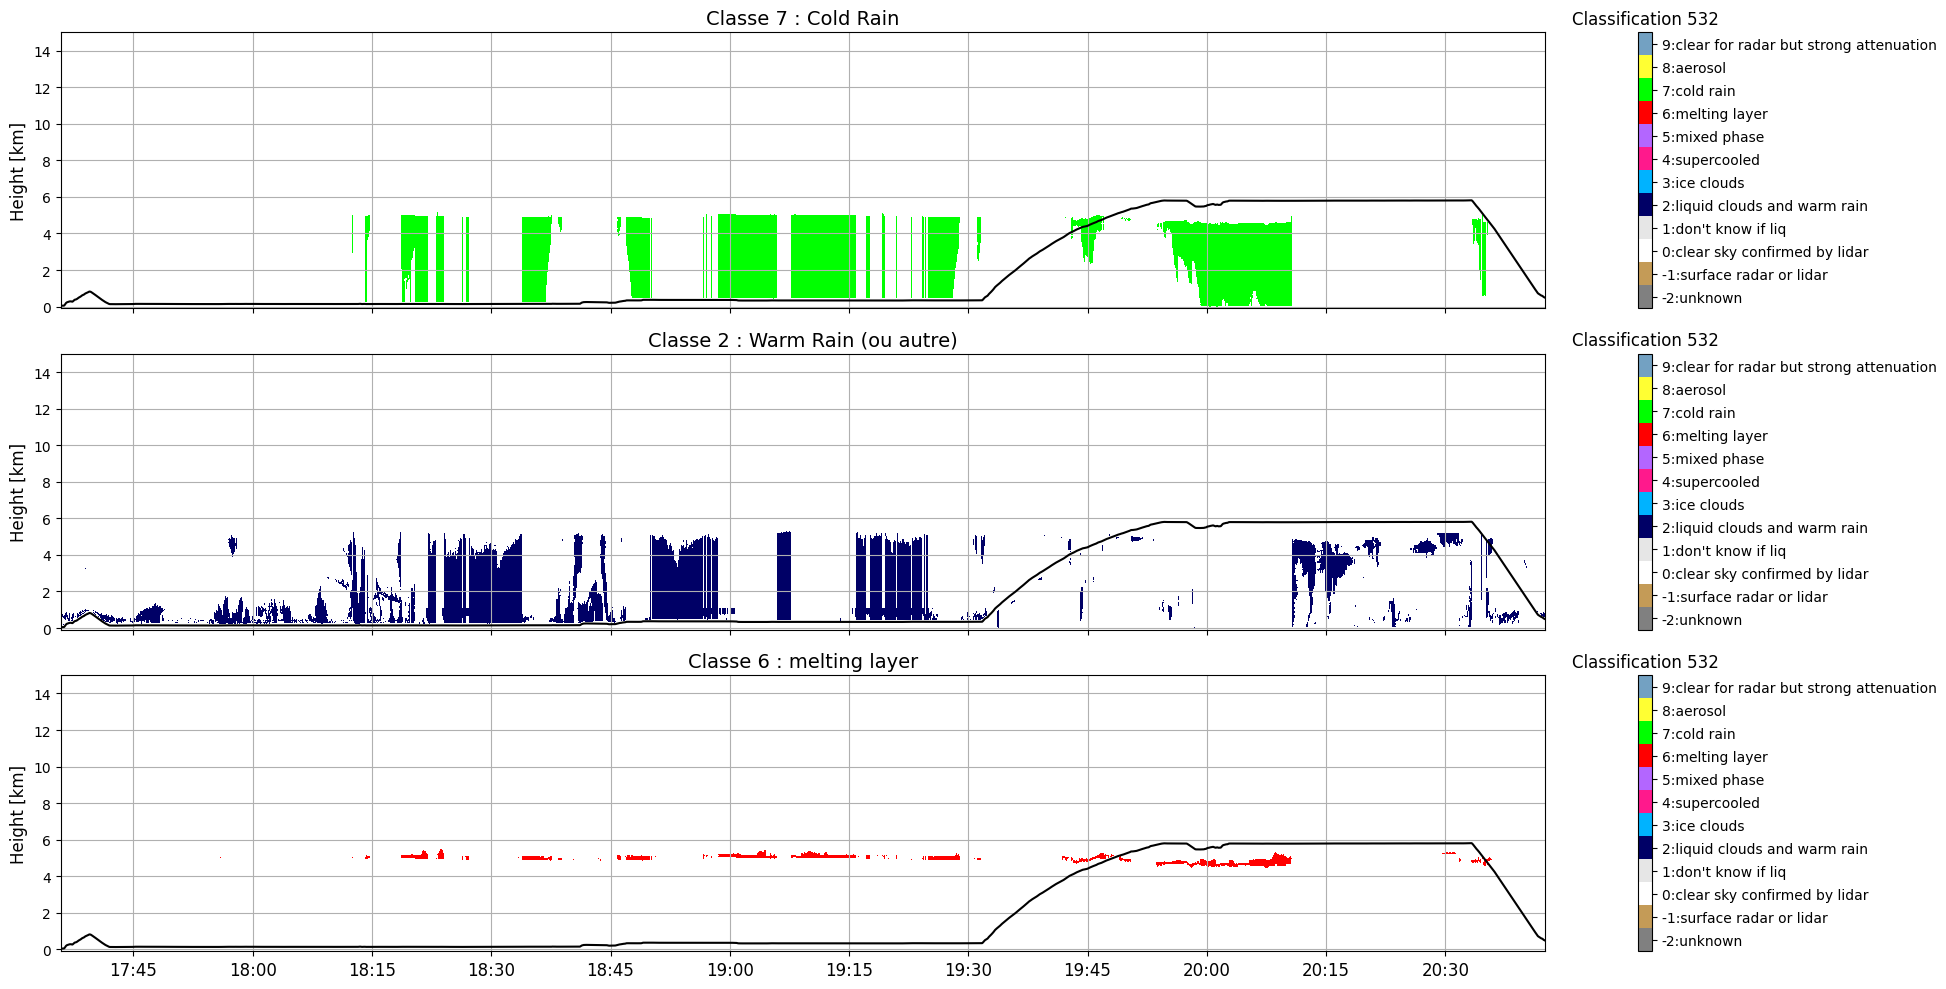

In [49]:
# Définir les classes à afficher et leurs titres
classes = [(7, "Classe 7 : Cold Rain"), (2, "Classe 2 : Warm Rain (ou autre)"),(6,"Classe 6 : melting layer")]
masked_data_list = [
    np.ma.masked_where(rali.rali_target_classification_532 != val, rali.rali_target_classification_532)
    for val, _ in classes
]

fig, axs = plt.subplots(3, 1, figsize=(20, 10), dpi=100, sharex=True)

for ax, data, (val, title) in zip(axs, masked_data_list, classes):
    pcm = ax.pcolormesh(rali.time, rali.height_2D.T, data.T, cmap=cmap_TC_flag)
    ax.plot(rali.time, rali.altitude, 'k')
    ax.grid()
    ax.set_xticks(tt)
    ax.set_xticklabels(ticklab, fontsize=12)
    ax.set_ylim(h_min, h_max)
    ax.set_ylabel("Height [km]", fontsize=12)
    ax.set_title(title, fontsize=14)

    pcm.set_clim(TC_flag_min, TC_flag_max)
    cb = fig.colorbar(pcm, ax=ax)
    tick_locs = ((np.arange(n_TC_flag) + 0.5) * (n_TC_flag - 1) / n_TC_flag) + TC_flag_min
    cb.set_ticks(tick_locs)
    cb.set_ticklabels(labels_TC_flag)
    cb.ax.set_title("Classification 532", fontsize=12)

axs[-1].set_xlim(np.min(rali.time), np.max(rali.time))
plt.tight_layout()
plt.show()


In [50]:
# Liste des classes à extraire (modifiable facilement)
classes_to_include = [2, 7]

# Accès aux données utiles
classif = rali.rali_target_classification_532  # shape: (time, height)
heights = rali.height_2D                       # shape: (time, height)
times = rali.time

# Initialisation des listes de résultats
base_altitudes = []
top_altitudes = []
thicknesses = []

# Boucle sur chaque profil temporel
for i in range(classif.shape[0]):
    profile = classif[i, :]        # classification à l’instant i
    height_profile = heights[i, :] # hauteur correspondante

    # Masque sur les classes sélectionnées
    combined_mask = np.isin(profile, classes_to_include)
    selected_heights = height_profile[combined_mask]

    if len(selected_heights) > 0:
        base = np.min(selected_heights)
        top = np.max(selected_heights)
        thickness = top - base
    else:
        base = np.nan
        top = np.nan
        thickness = np.nan

    base_altitudes.append(base)
    top_altitudes.append(top)
    thicknesses.append(thickness)


### Test diagrame en barre

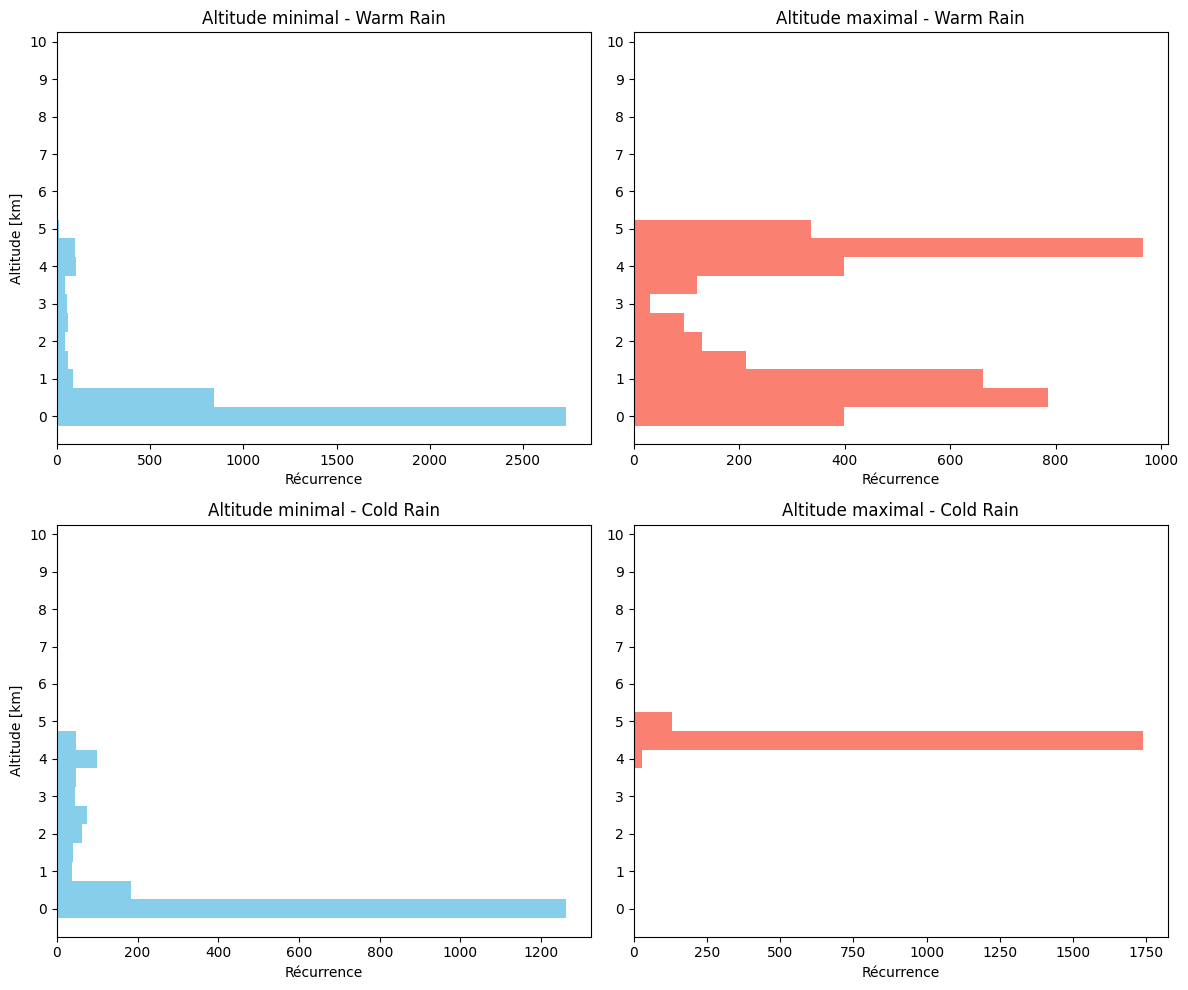

In [ ]:
#Altitudes minimales, maximales et épaisseurs (diagramme en barres)
import matplotlib.pyplot as plt
import numpy as np

# Liste des classes à traiter (tu peux en ajouter autant que nécessaire)
classes_to_include = [2, 7]
class_names = {2: "Warm Rain", 7: "Cold Rain"}

# Accès aux données utiles
classif = rali.rali_target_classification_532
heights = rali.height_2D

# Définir les bins
bins = np.arange(0, 10.5, 0.5)
yticks = np.arange(bins[0], bins[-1]+1, 1)

# Initialisation de la figure
fig, axs = plt.subplots(len(classes_to_include), 2, figsize=(12, 5 * len(classes_to_include)), sharey=True)

if len(classes_to_include) == 1:
    axs = np.array([axs])  # si une seule classe, on garde la structure 2D

for i, class_id in enumerate(classes_to_include):
    base_altitudes = []
    top_altitudes = []

    for t in range(classif.shape[0]):
        profile = classif[t, :]
        height_profile = heights[t, :]

        mask = (profile == class_id)
        selected_heights = height_profile[mask]

        if len(selected_heights) > 0:
            base = np.min(selected_heights)
            top = np.max(selected_heights)
        else:
            base = np.nan
            top = np.nan

        base_altitudes.append(base)
        top_altitudes.append(top)

    base_altitudes = np.array(base_altitudes)
    top_altitudes = np.array(top_altitudes)

    base_hist, _ = np.histogram(base_altitudes[~np.isnan(base_altitudes)], bins=bins)
    top_hist, _ = np.histogram(top_altitudes[~np.isnan(top_altitudes)], bins=bins)

    # Affichage histogrammes
    axs[i, 0].barh(bins[:-1], base_hist, height=0.5, color='skyblue')
    axs[i, 0].set_title(f"Altitude minimal - {class_names.get(class_id, f'Classe {class_id}')}")
    axs[i, 0].set_xlabel("Récurrence")
    axs[i, 0].set_ylabel("Altitude [km]")
    axs[i, 0].set_yticks(yticks)

    axs[i, 1].barh(bins[:-1], top_hist, height=0.5, color='salmon')
    axs[i, 1].set_title(f"Altitude maximal - {class_names.get(class_id, f'Classe {class_id}')}")
    axs[i, 1].set_xlabel("Récurrence")
    axs[i, 1].tick_params(axis='y', labelleft=True)
    axs[i, 1].set_yticks(yticks)

plt.tight_layout()
plt.show()


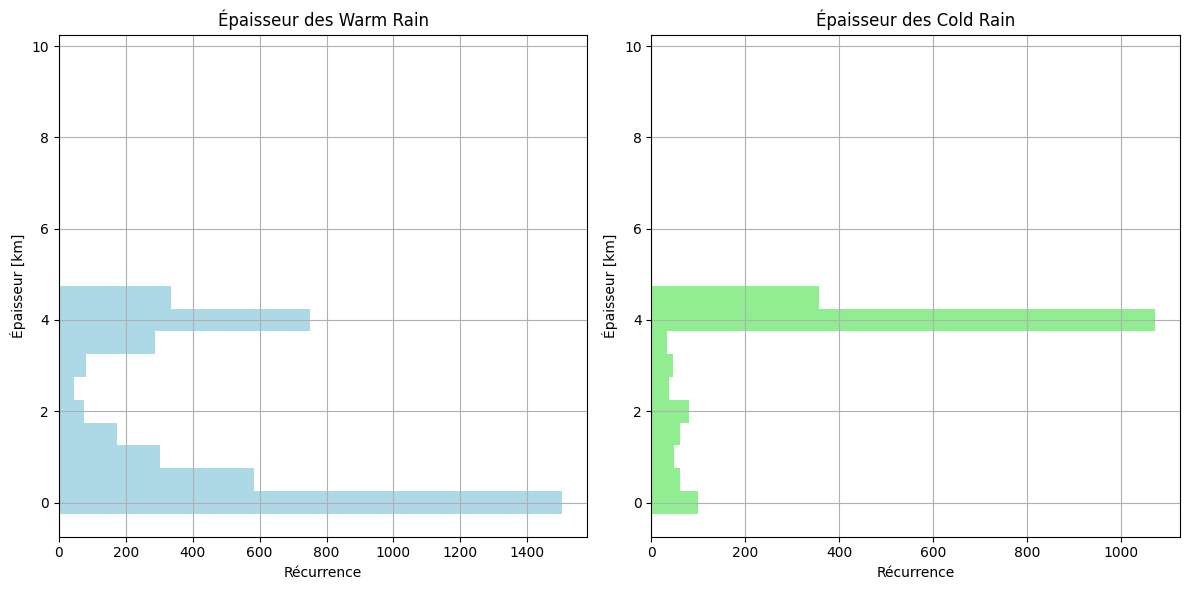

In [52]:
# %%
import numpy as np
import matplotlib.pyplot as plt

# Définir les bins d’épaisseur
thickness_bins = np.arange(0, 10.5, 0.5)
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

for idx, class_id in enumerate(classes_to_include):
    base_altitudes = []
    top_altitudes = []
    thicknesses = []

    for t in range(classif.shape[0]):
        profile = classif[t, :]
        height_profile = heights[t, :]
        mask = (profile == class_id)
        selected_heights = height_profile[mask]

        if len(selected_heights) > 0:
            base, top = np.min(selected_heights), np.max(selected_heights)
            thickness = top - base
        else:
            base, top, thickness = np.nan, np.nan, np.nan

        base_altitudes.append(base)
        top_altitudes.append(top)
        thicknesses.append(thickness)

    thicknesses = np.array(thicknesses)
    # Histogramme des épaisseurs
    thick_hist, _ = np.histogram(thicknesses[~np.isnan(thicknesses)], bins=thickness_bins)

    axs[idx].barh(thickness_bins[:-1], thick_hist, height=0.5, color='lightgreen' if class_id == 7 else 'lightblue')
    axs[idx].set_title(f"Épaisseur des {class_names.get(class_id, f'Classe {class_id}')}")
    axs[idx].set_xlabel("Récurrence")
    axs[idx].set_ylabel("Épaisseur [km]")
    axs[idx].grid(True)

plt.tight_layout()
plt.show()

### Répartition des differentes classe (hauteur max, hauteur min ...)

In [ ]:
#Chargement optimisé des differentes variables d'un fichier RALI
def load_essential_rali(file_path, variables_to_keep):
    """
    Charge uniquement les variables essentielles d'un fichier RALI.
    
    Args:
        file_path (str): chemin du fichier NetCDF.
        variables_to_keep (list of str): noms des variables à garder.
    
    Returns:
        dict: variables extraites sous forme de np.array ou np.ma.array.
    """
    rali_data = {}
    with netCDF4.Dataset(file_path, 'r') as nc:
        for var_name in variables_to_keep:
            if var_name in nc.variables:
                data = nc.variables[var_name][:]
                # Conversion en float32 pour économie mémoire
                if data.dtype != np.float32:
                    data = data.astype(np.float32)
                rali_data[var_name] = data
            else:
                print(f"Variable {var_name} non trouvée dans {file_path}")
    return rali_data


In [ ]:
#Different variables à garder
variables_to_keep = ['rali_target_classification_532', 'height_2D']

all_rali_data = []

for file_in in files_rali:
    data = load_essential_rali(file_in, variables_to_keep)
    all_rali_data.append(data)


In [ ]:
#Extraction des altitudes minimales et maximales par classe
def extraire_altitudes_par_classe(all_rali_data, classe_cible):
    base_altitudes_all = []
    top_altitudes_all = []
    std_base_all = []
    std_top_all = []

    for rali in all_rali_data:
        base_altitudes = []
        top_altitudes = []

        profile_data = rali['rali_target_classification_532']
        height_data = rali['height_2D']

        for t in range(profile_data.shape[0]):
            profile = profile_data[t, :]
            height_profile = height_data[t, :]

            mask = (profile == classe_cible)
            selected_heights = height_profile[mask]

            if len(selected_heights) > 0:
                base_altitudes.append(np.min(selected_heights))
                top_altitudes.append(np.max(selected_heights))
            else:
                base_altitudes.append(np.nan)
                top_altitudes.append(np.nan)

        base_altitudes_all.append(base_altitudes)
        top_altitudes_all.append(top_altitudes)
        std_base_all.append(np.nanstd(base_altitudes))
        std_top_all.append(np.nanstd(top_altitudes))

    return base_altitudes_all, top_altitudes_all, std_base_all, std_top_all


In [ ]:
#Generation du graphique des altitudes minimales et maximales

def tracer_violin(data_all, stds, titre, ylabel, cmap_name='cividis', vol_start=24):
    ALPHA = 0.8
    COUL_MOY, COUL_STD = 'darkblue', 'crimson'

    data_all_clipped = []
    for day_data in data_all:
        day_array = np.array(day_data)
        day_array = np.where(day_array < 0, np.nan, day_array)
        data_all_clipped.append(day_array)

    quantites = [np.sum(~np.isnan(day)) for day in data_all_clipped]

    # Filtrer les données avec peu d’occurrences (exclure si < 10)
    seuil = 10
    data_all_clipped = [d for d, q in zip(data_all_clipped, quantites) if q >= seuil]
    stds = [s for s, q in zip(stds, quantites) if q >= seuil]
    quantites = [q for q in quantites if q >= seuil]

    norm = mcolors.Normalize(vmin=min(quantites), vmax=max(quantites))
    cmap = cm.get_cmap(cmap_name)
    couleurs = [cmap(norm(q)) for q in quantites]

    fig, ax = plt.subplots(figsize=(12, 6))

    for i, (data, std) in enumerate(zip(data_all_clipped, stds), start=1):
        data = data[~np.isnan(data)]
        if len(data) == 0:
            continue
        vp = ax.violinplot(data, [i], showmeans=True, showextrema=False, widths=0.8)
        vp['bodies'][0].set_facecolor(couleurs[i-1])
        vp['bodies'][0].set_alpha(ALPHA)
        vp['cmeans'].set_edgecolor(COUL_MOY)

        moyenne = np.mean(data)
        bas = max(moyenne - std, 0)
        haut = moyenne + std
        ax.vlines(i, bas, haut, colors=COUL_STD, linewidth=2)

    x_labels = [f"Vol {vol_start + i - 1}" for i in range(1, len(data_all_clipped)+1)]
    ax.set_xticks(range(1, len(data_all_clipped) + 1))
    ax.set_xticklabels(x_labels, rotation=45)
    ax.set_xlabel("n°Vols")

    ax.set_ylabel(ylabel)
    ax.set_title(titre)
    ax.grid(True, linestyle='--', alpha=0.7)

    custom_lines = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor=COUL_MOY, markersize=8),
        Line2D([0], [0], color=COUL_STD, lw=2)
    ]
    ax.legend(custom_lines, ['Moyenne', '± Écart-type'], loc='upper right')

    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, pad=0.02)
    cbar.set_label('Quantité de profils valides', fontsize=12)

    plt.tight_layout()
    plt.show()


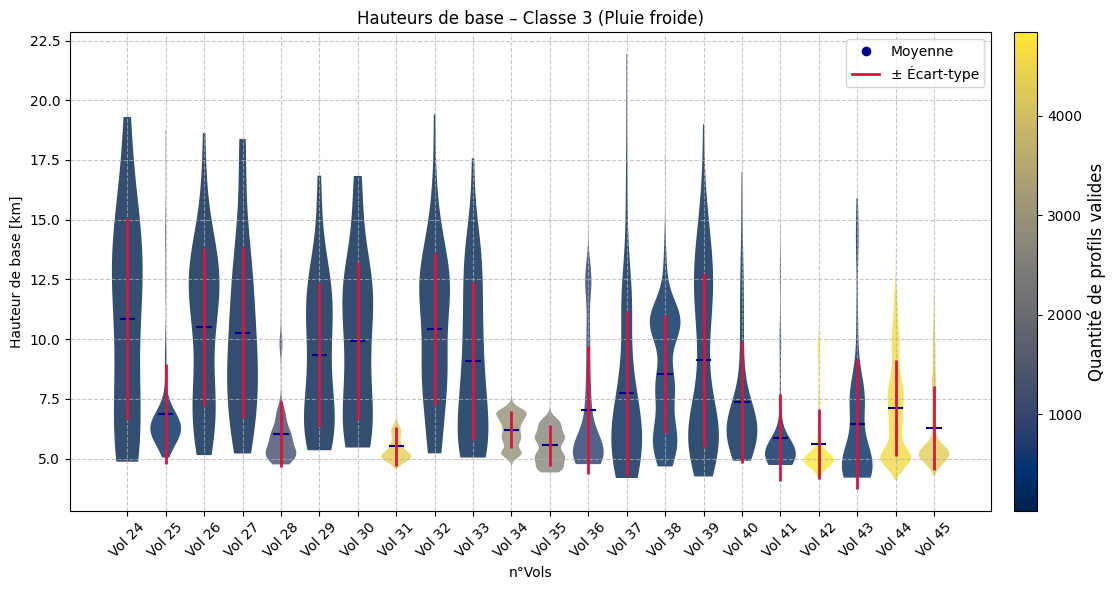

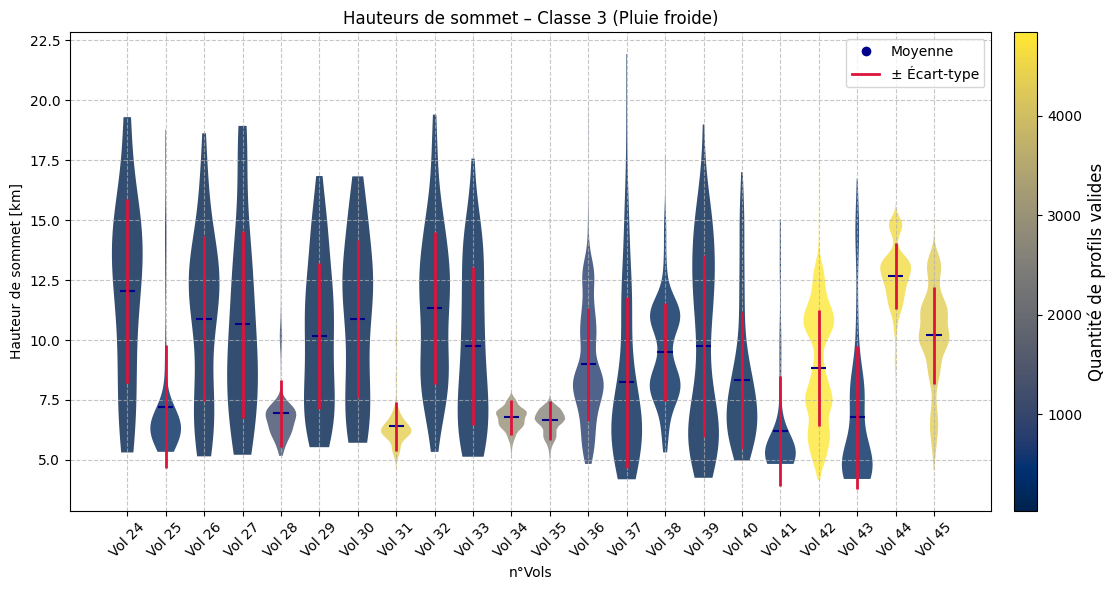

In [ ]:
#Graphique pour classe 2 (pluie chaude)
classe_cible = 2  # Exemple: classe 2 "pluie chaude"

base_alt, top_alt, std_base, std_top = extraire_altitudes_par_classe(all_rali_data, classe_cible)

tracer_violin(base_alt, std_base, f"Hauteurs de base – Classe {classe_cible} (Pluie chaude)", "Hauteur de base [km]")
tracer_violin(top_alt, std_top, f"Hauteurs de sommet – Classe {classe_cible} (Pluie chaude)", "Hauteur de sommet [km]")


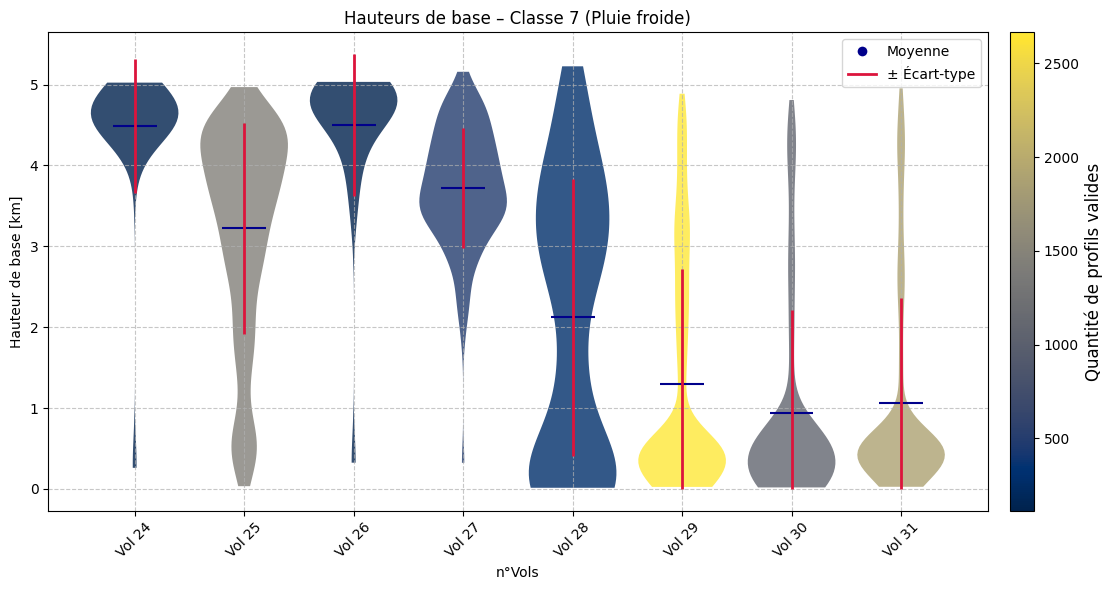

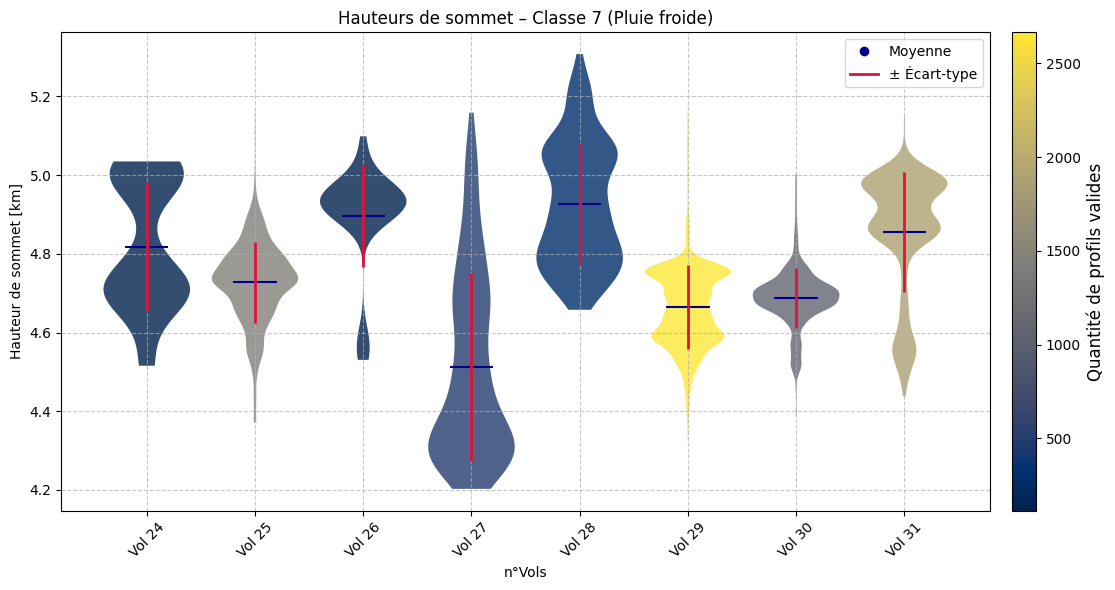

In [84]:
#Graphique pour classe 7 (pluie chaude)
classe_cible = 7  # Exemple: classe 7 "pluie froide"

base_alt, top_alt, std_base, std_top = extraire_altitudes_par_classe(all_rali_data, classe_cible)

tracer_violin(base_alt, std_base, f"Hauteurs de base – Classe {classe_cible} (Pluie froide)", "Hauteur de base [km]")
tracer_violin(top_alt, std_top, f"Hauteurs de sommet – Classe {classe_cible} (Pluie froide)", "Hauteur de sommet [km]")


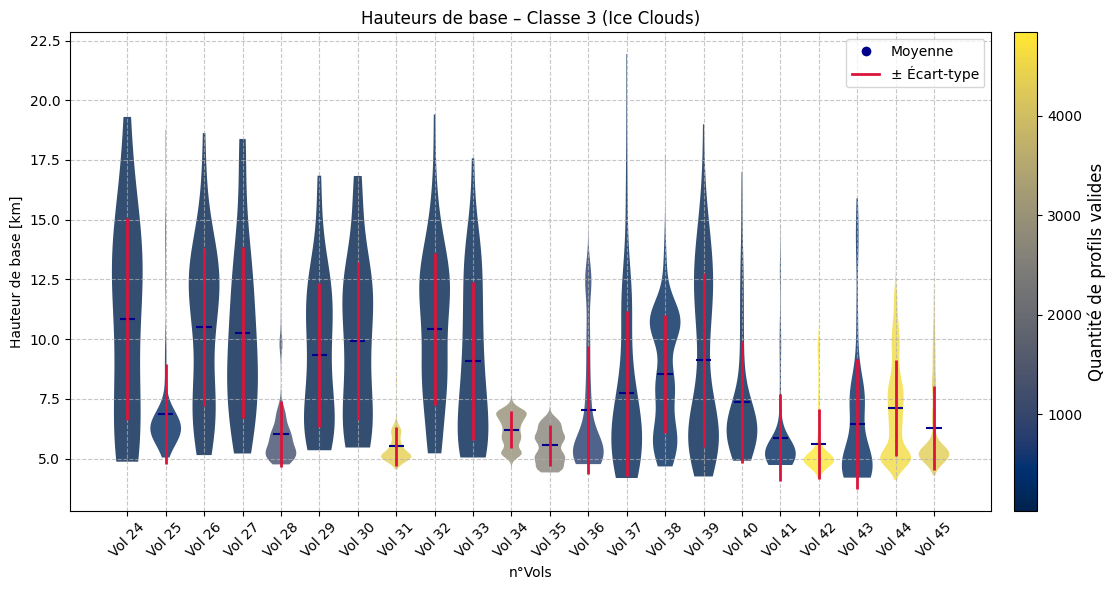

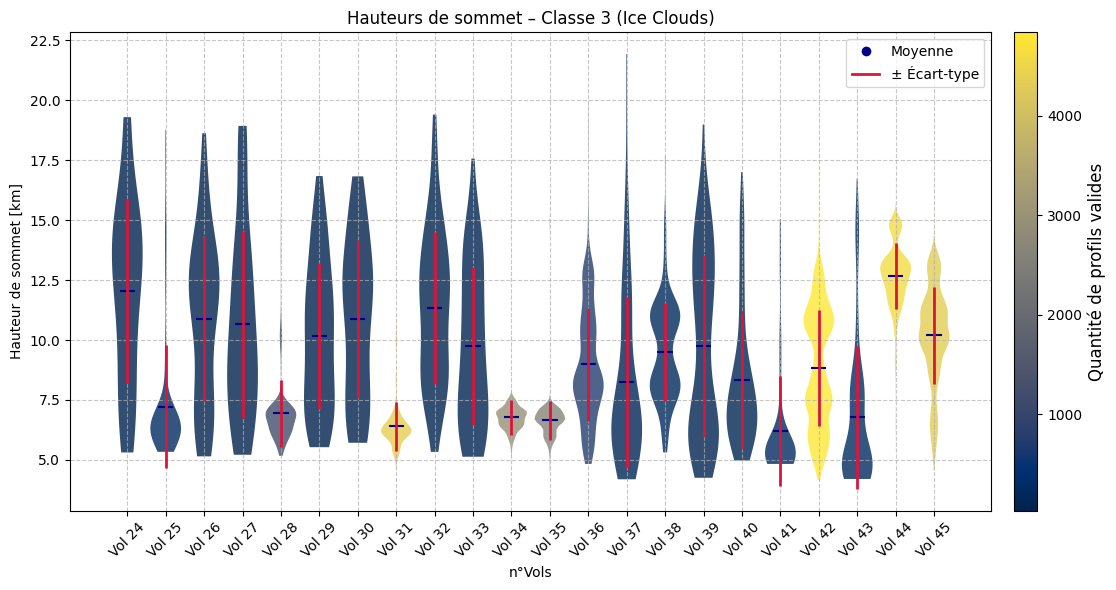

In [85]:
#Graphique pour classe 3 (Ice clouds)
classe_cible = 3  # Exemple: classe 3 "Ice clouds"

base_alt, top_alt, std_base, std_top = extraire_altitudes_par_classe(all_rali_data, classe_cible)

tracer_violin(base_alt, std_base, f"Hauteurs de base – Classe {classe_cible} (Ice Clouds)", "Hauteur de base [km]")
tracer_violin(top_alt, std_top, f"Hauteurs de sommet – Classe {classe_cible} (Ice Clouds)", "Hauteur de sommet [km]")


### Test stockage dans memoire vive

In [64]:
import gc

del data  # par exemple, pour libérer variable temporaire
gc.collect()  # pour forcer nettoyage mémoire


16618

In [69]:
# Cellule 2 : Extraction des labels et codes pour target classification 532 nm (à partir du dictionnaire TC_tab_color_and_lab)
# Extraction des codes classes (int) et des labels texte (sans le code) de TC_tab_color_and_lab
class_codes = []
class_labels = []
for k, v in sorted(TC_tab_color_and_lab.items()):
    # v[0] exemple : "-2:unknown"
    code_str, label = v[0].split(":", 1)
    class_codes.append(int(code_str))
    class_labels.append(label.strip())



In [71]:
# Cellule 3 : Classe plotter
class HeightByClassPlotter:
    def __init__(self, folder_path, file_pattern="target_classification_rali_MAESTRO_*_nshots_100_v1.0.nc"):
        self.folder_path = folder_path
        self.file_pattern = file_pattern
        self.files = sorted(glob.glob(f"{folder_path}/{file_pattern}"))
    
    def load_and_extract(self, class_number):
        diffs = []
        days = []
        for f in self.files:
            with nc.Dataset(f) as ds:
                classif = ds.variables["rali_target_classification_532"][:]
                height = ds.variables["height_2D"][:]
                mask = (classif == class_number)
                if np.any(mask):
                    h_selected = height[mask]
                    diff = h_selected.max() - h_selected.min()
                else:
                    diff = 0
                diffs.append(diff)
                day = f.split('_')[3]  # Extraire la date du nom de fichier
                days.append(day)

        mean_diff = np.mean(diffs)
        std_diff = np.std(diffs)
        return days, diffs, mean_diff, std_diff

    def plot_class_height(self, class_number):
        days, diffs, mean_diff, std_diff = self.load_and_extract(class_number)
        plt.figure(figsize=(12,6))
        sns.barplot(x=days, y=diffs, color="steelblue")
        plt.errorbar(range(len(days)), diffs, yerr=std_diff, fmt='none', ecolor='red', capsize=5)
        plt.xticks(rotation=45)
        plt.ylabel("Épaisseur (hauteur max - min) [km]")
        # Trouver label texte correspondant
        if class_number in class_codes:
            label = class_labels[class_codes.index(class_number)]
        else:
            label = f"Classe {class_number}"
        plt.title(f"Épaisseur de la classe '{label}' par jour (max-min hauteur)")
        plt.tight_layout()
        plt.show()


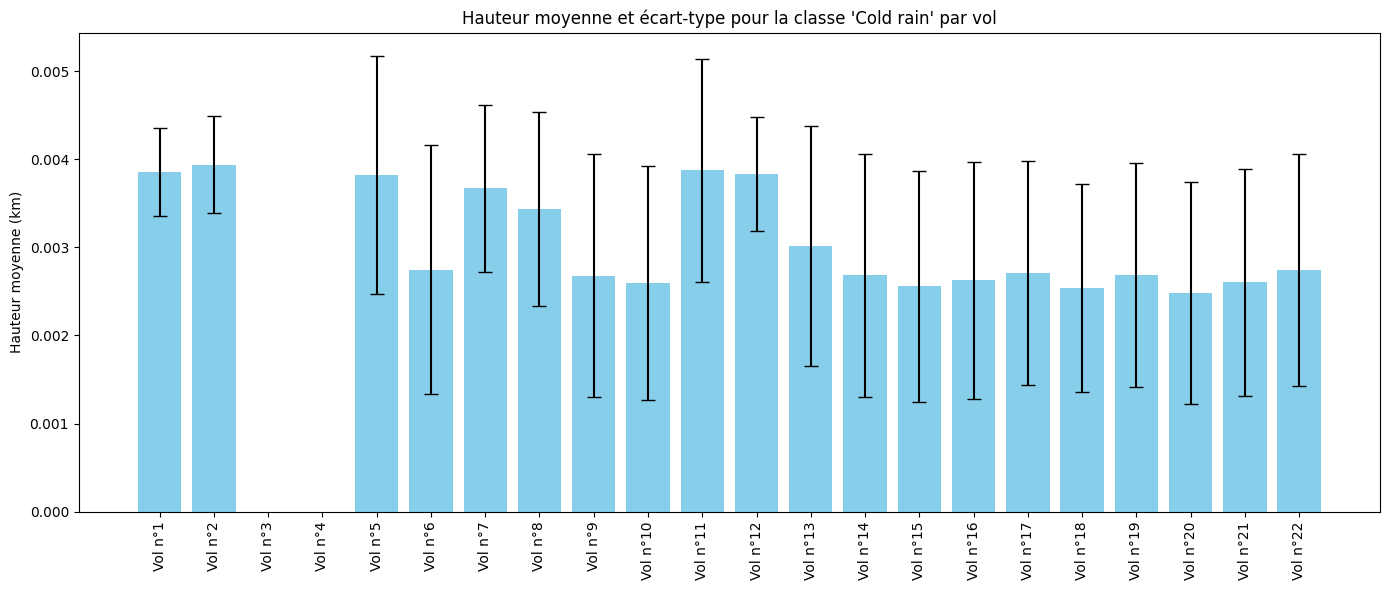

In [ ]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import gc

data_dir = "./data/"
nc_files = sorted(glob.glob(os.path.join(data_dir, "*.nc")))

class_labels = {
    9: "Clear strong atten.",
    8: "Aerosol",
    7: "Cold rain",
    6: "Melting layer",
    5: "Mixed phase",
    4: "Supercooled",
    3: "Ice clouds",
    2: "Warm rain",
    1: "Uncertain liquid",
    0: "Clear (lidar)",
    -1: "Surface return",
    -2: "Unknown"
}

mask_var_name = 'rali_target_classification_532'
selected_class = 7
selected_label = class_labels[selected_class]

means = []
stds = []

for i, file_path in enumerate(nc_files, start=1):
    with Dataset(file_path, 'r') as nc:
        if mask_var_name not in nc.variables or 'height_2D' not in nc.variables:
            print(f"Variables manquantes dans {file_path}")
            continue
        
        mask = nc.variables[mask_var_name][:]
        height = nc.variables['height_2D'][:]
        
        indices = np.where(mask == selected_class)
        if len(indices[0]) == 0:
            means.append(np.nan)
            stds.append(np.nan)
        else:
            h_vals = height[indices] / 1000  # en km
            means.append(np.nanmean(h_vals))
            stds.append(np.nanstd(h_vals))

flight_labels = [f"Vol n°{i}" for i in range(1, len(means) + 1)]

plt.figure(figsize=(14, 6))
plt.bar(flight_labels, means, yerr=stds, capsize=5, color='skyblue')
plt.xticks(rotation=90)
plt.ylabel('Hauteur moyenne (km)')
plt.title(f"Hauteur moyenne et écart-type pour la classe '{selected_label}' par vol")
plt.tight_layout()
plt.show()


In [107]:
import glob
import os
import re
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from netCDF4 import Dataset

def plot_epaisseur_par_jour(selected_class=7, data_dir="./data/"):
    nc_files = sorted(glob.glob(os.path.join(data_dir, "*.nc")))
    mask_var_name = 'rali_target_classification_532'
    epaisseurs_par_date = defaultdict(list)
    date_regex = re.compile(r"MAESTRO_(\d{8})_F\d+_")
    
    for file_path in nc_files:
        match = date_regex.search(os.path.basename(file_path))
        if not match:
            print(f"Date non trouvée dans le fichier {file_path}, fichier ignoré")
            continue
        date_str = match.group(1)
        date_fmt = f"{date_str[:4]}-{date_str[4:6]}-{date_str[6:]}"
        
        try:
            with Dataset(file_path, 'r') as nc:
                if mask_var_name not in nc.variables or 'height_2D' not in nc.variables:
                    print(f"Variables manquantes dans {file_path}, fichier ignoré")
                    continue
                
                mask = nc.variables[mask_var_name][:]
                height = nc.variables['height_2D'][:]
                
                indices = np.where(mask == selected_class)
                if len(indices[0]) == 0:
                    continue
                
                h_vals = height[indices]
                min_h = np.nanmin(h_vals)
                max_h = np.nanmax(h_vals)
                epaisseur = max_h - min_h
                
                epaisseurs_par_date[date_fmt].append(epaisseur)
                
        except Exception as e:
            print(f"Erreur avec le fichier {file_path} : {e}")
    
    dates = sorted(epaisseurs_par_date.keys())
    moyennes = []
    ecarts_types = []
    counts = []
    
    for d in dates:
        vals = np.array(epaisseurs_par_date[d])
        moyennes.append(np.nanmean(vals))
        ecarts_types.append(np.nanstd(vals))
        counts.append(len(vals))
    
    norm = mcolors.Normalize(vmin=min(counts), vmax=max(counts))
    cmap = cm.Blues
    colors = [cmap(norm(c)) for c in counts]
    
    fig, ax = plt.subplots(figsize=(12, 6))
    bars = ax.bar(dates, moyennes, yerr=ecarts_types, capsize=5, color=colors)
    ax.set_xticklabels(dates, rotation=45)
    ax.set_xlabel("Date")
    ax.set_ylabel("Épaisseur moyenne (km)")
    ax.set_title(f"Épaisseur verticale moyenne de la classe {selected_class} par jour\n(couleur selon nombre de données)")
    
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, pad=0.02)
    cbar.set_label('Nombre de points par jour')
    
    plt.tight_layout()
    plt.show()


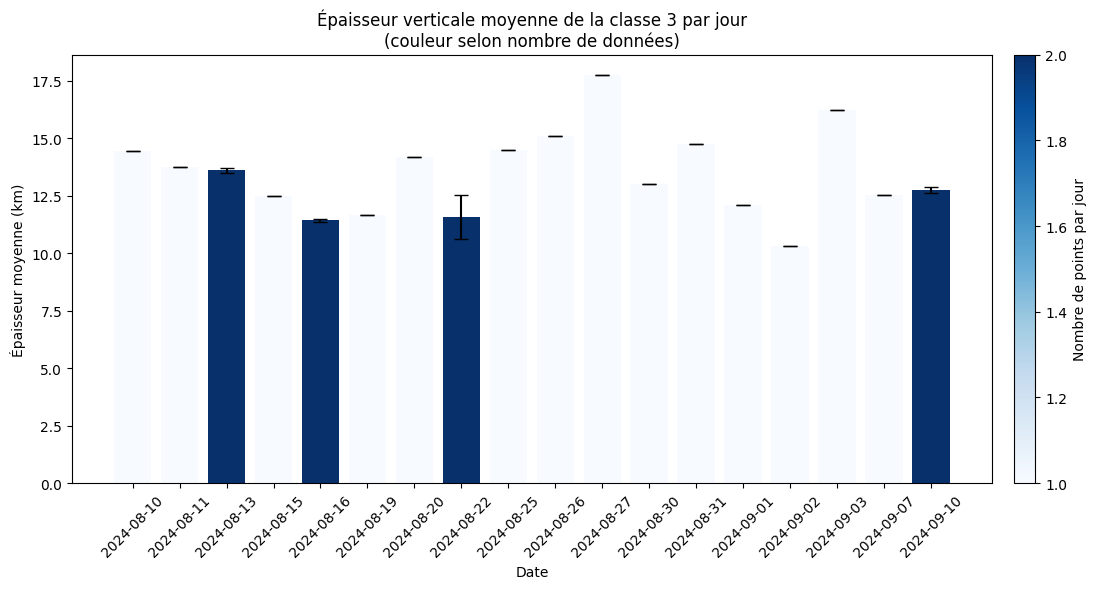

In [108]:
# Exemple : tracer pour la classe cold rain (7)
plot_epaisseur_par_jour(selected_class=3)


In [92]:
for d in dates:
    vals = np.array(epaisseurs_par_date[d])
    print(f"{d} : moyenne = {np.nanmean(vals):.3f}, std = {np.nanstd(vals):.3f}, nb points = {len(vals)}")


2024-08-10 : moyenne = 1.675, std = 0.000, nb points = 1
2024-08-11 : moyenne = 1.854, std = 0.000, nb points = 1
2024-08-15 : moyenne = 4.775, std = 0.000, nb points = 1
2024-08-16 : moyenne = 4.036, std = 0.807, nb points = 2
2024-08-19 : moyenne = 5.133, std = 0.000, nb points = 1
2024-08-20 : moyenne = 4.719, std = 0.000, nb points = 1
2024-08-22 : moyenne = 4.659, std = 0.116, nb points = 2
2024-08-25 : moyenne = 4.836, std = 0.000, nb points = 1
2024-08-26 : moyenne = 5.294, std = 0.000, nb points = 1
2024-08-27 : moyenne = 4.719, std = 0.000, nb points = 1
2024-08-30 : moyenne = 4.482, std = 0.000, nb points = 1
2024-08-31 : moyenne = 4.603, std = 0.000, nb points = 1
2024-09-01 : moyenne = 4.436, std = 0.000, nb points = 1
2024-09-02 : moyenne = 4.023, std = 0.000, nb points = 1
2024-09-03 : moyenne = 5.142, std = 0.000, nb points = 1
2024-09-07 : moyenne = 4.305, std = 0.000, nb points = 1
2024-09-10 : moyenne = 5.055, std = 0.070, nb points = 2
